In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
dj.conn().connect()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pipeline.ingest import behavior as behavior_ingest
from pipeline.ingest import ephys as ephys_ingest
from pipeline import lab, get_schema_name, experiment, foraging_analysis, report, ephys, histology, psth_foraging, ccf
import pipeline.shell as shell
from pipeline import psth_foraging, foraging_model, foraging_analysis
from pipeline.plot import unit_psth

shell.logsetup('INFO')
[hh for hh in dj.list_schemas() if 'hanhou' in hh]

from pipeline.psth_foraging import compute_unit_period_activity
from pipeline.util import _get_unit_independent_variable
from pipeline.plot.foraging_model_plot import plot_session_fitted_choice
from pipeline.plot.unit_psth import plot_unit_period_tuning

Connecting hanhou@datajoint.mesoscale-activity-map.org:3306


# Unit PSTH

## Previous pipeline

First, make sure the `psth_foraging.TrialCondition` have the correct conditions. <br> Note that I separate foraging ephys analysis to another new schema `psth_foraging`.

In [2]:
from pipeline import psth_foraging

In [3]:
psth_foraging.TrialCondition()

*trial_condition_name    trial_condition_hash                 trial_condition_func         trial_cond
+----------------------+ +----------------------------------+ +--------------------------+ +--------+
LR_all_noearlylick       c1ed68f9625b5de968b8831c9e82a659     _get_trials_exclude_stim     =BLOB=    
LR_hit                   84e4391a724088347de05c4b4ab9e548     _get_trials_exclude_stim     =BLOB=    
LR_hit_noearlylick       ad875075498842aab833752d4fc5dc9f     _get_trials_exclude_stim     =BLOB=    
LR_miss_noearlylick      009703e23db2b60b0a62faada17d33dc     _get_trials_exclude_stim     =BLOB=    
L_all_noearlylick        1aef3cc13729a98fa71e6800f8fd59d8     _get_trials_exclude_stim     =BLOB=    
L_hit                    e699edb5e56824e6366722b976ccd135     _get_trials_exclude_stim     =BLOB=    
L_hit_noearlylick        caa4861706638bf200f1e90eda5ea428     _get_trials_exclude_stim     =BLOB=    
L_miss                   d21967626dcdeb446e0b870696ebfd48     _get_trials_exclude_stim     =BLOB=    
L_miss_noearlylick       e7ff1aea5c2f3eb1f9828cf0ba3b9ca8     _get_trials_exclude_stim     =BLOB=    
R_all_noearlylick        0a67e26a0a8083f83813ed95ca0731f4     _get_trials_exclude_stim     =BLOB=    
R_hit                    7a9e099ab648c4b9e7b32688bddf7d2a     _get_trials_exclude_stim     =BLOB=    
R_hit_noearlylick        911adc826d490eee4117638317ba51df     _get_trials_exclude_stim     =BLOB=    
R_miss                   b12d27b50e362679cf3cd7e753043945     _get_trials_exclude_stim     =BLOB=    
R_miss_noearlylick       5d70dce8a7413fbd285fb28924f6ba3f     _get_trials_exclude_stim     =BLOB=    
 (Total: 14)

In [4]:
psth_foraging.TrialCondition.get_trials('foraging_L_hit_noearlylick').fetch(format='frame', limit=10)

DataJointError: fetch1 should only return one tuple. 0 tuples found

Here I need to run `foraging_populate.py` to do parallel population of `psth_foraging.UnitPsth`

Check progress of populating PSTH

In [ ]:
schema = dj.schema(get_schema_name('psth_foraging'))
schema.jobs

In [ ]:
schema.jobs.fetch('key')

In [ ]:
length = len(psth_foraging.UnitPsth())
ratio = length / len(psth_foraging.UnitPsth.key_source)
print(f'ephys.Unit:{length}, {ratio:.2%}')

In [ ]:
schema.jobs.delete()

In [ ]:
dj.kill()

After populating PSTH (with some bug fixes), single unit PSTH can be plotted

In [ ]:
experiment.Session & 'session_date = "2021-04-29"'

In [ ]:
from pipeline.plot import unit_psth

In [ ]:
unit = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-29"') & 'insertion_number=1' & 'unit_uid=299').fetch1("KEY")
_ = unit_psth.plot_unit_psth_foraging(unit)

## New flexible PSTHs

In [5]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

### PSTH grouped by choice and outcome

In [ ]:
align_types=['trial_start', 'go_cue', 'first_lick_after_go_cue', 'iti_start', 'next_trial_start']

In [ ]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

In [ ]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key, align_types)

In [ ]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key, align_types=['iti_start', 'next_trial_start'], if_raster=False)

### PSTH grouped by value quantiles

In [ ]:
best_model = (foraging_model.FittedSessionModelComparison.BestModel & unit_key & 'model_comparison_idx = 1').fetch1('best_aic')
print(best_model)

In [ ]:
align_types=['trial_start', 'go_cue', 'first_lick_after_go_cue', 'iti_start', 'next_trial_start']
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=best_model, align_types=align_types, latent_variable='contra_action_value')

In [ ]:
align_types=['trial_start', 'first_lick_after_go_cue', 'iti_start', 'next_trial_start']
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=best_model, align_types=align_types, latent_variable='ipsi_action_value')

In [ ]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=best_model, align_types=align_types, latent_variable='relative_action_value_ic')

In [ ]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=best_model, align_types=align_types, latent_variable='total_action_value')

### More example neurons

####  PL

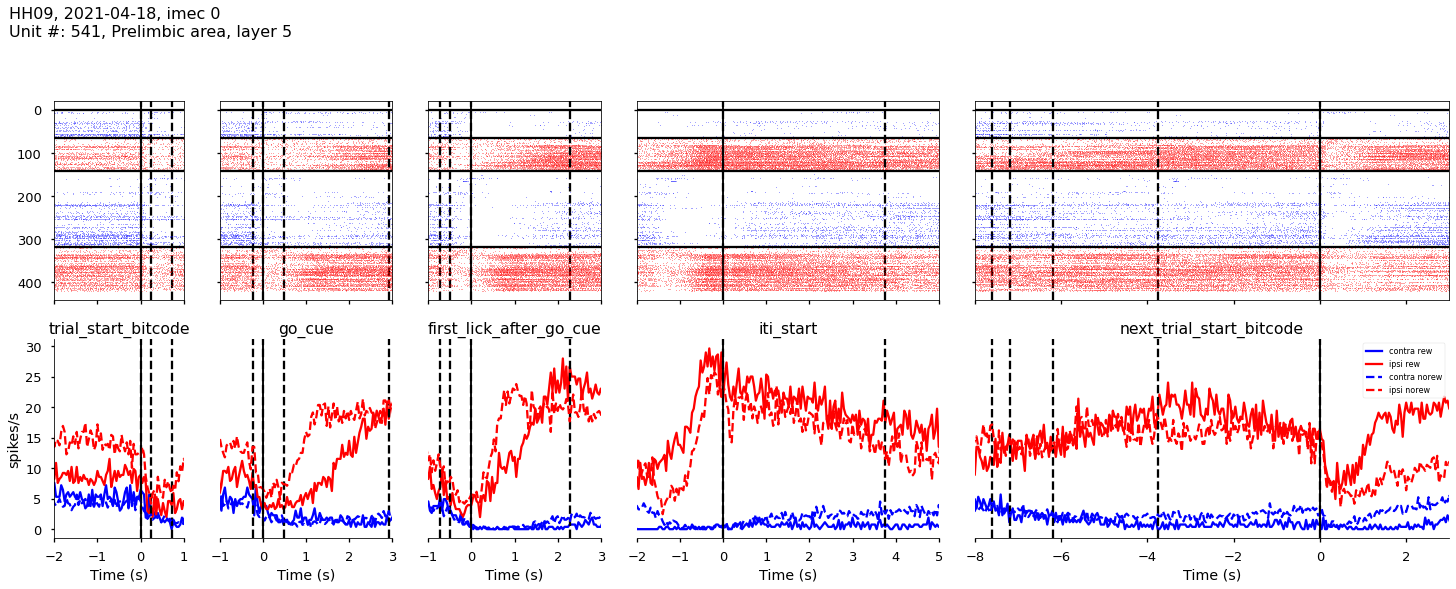

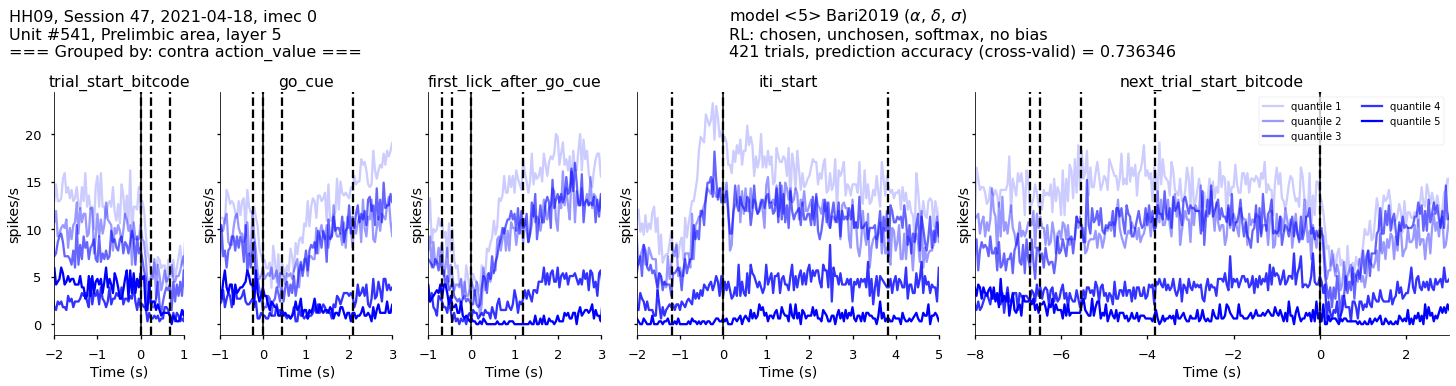

In [6]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=5)

In [ ]:
date, imec, unit = '2021-04-18', 0, 484
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

#### ALM

(<Figure size 2200x2800 with 5 Axes>, <Figure size 1560x1072.5 with 3 Axes>)

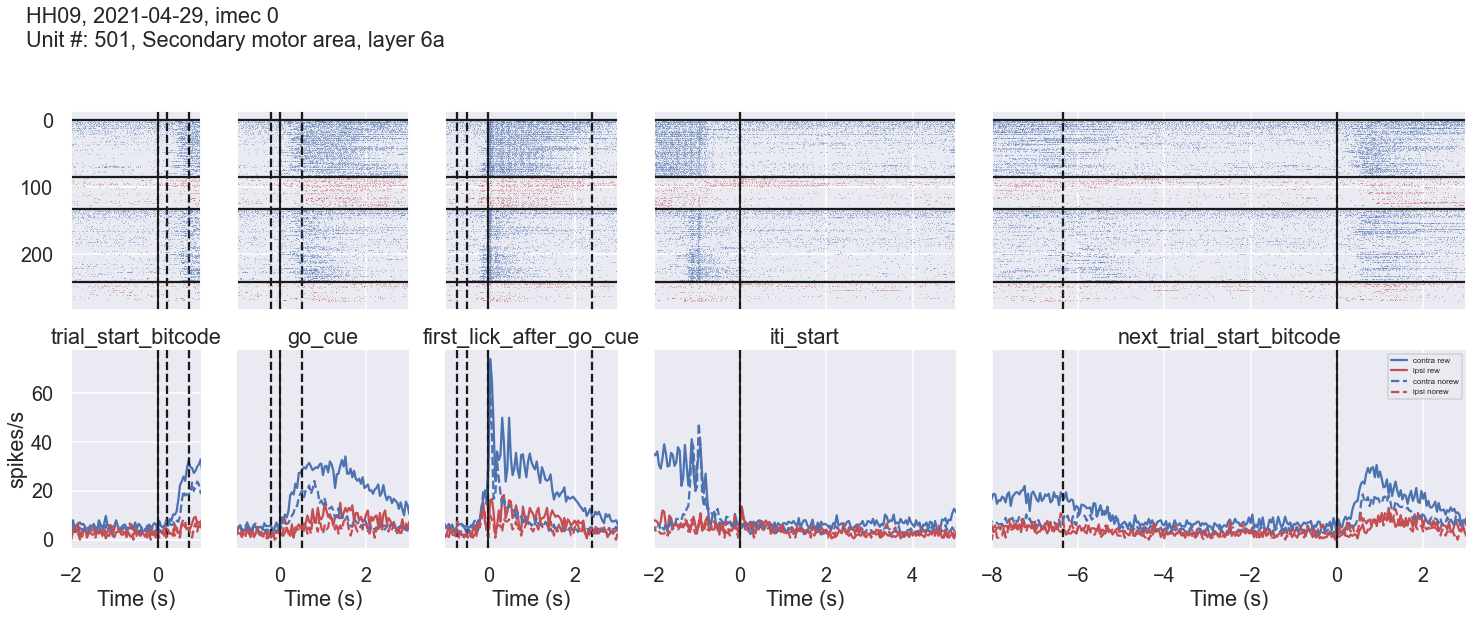

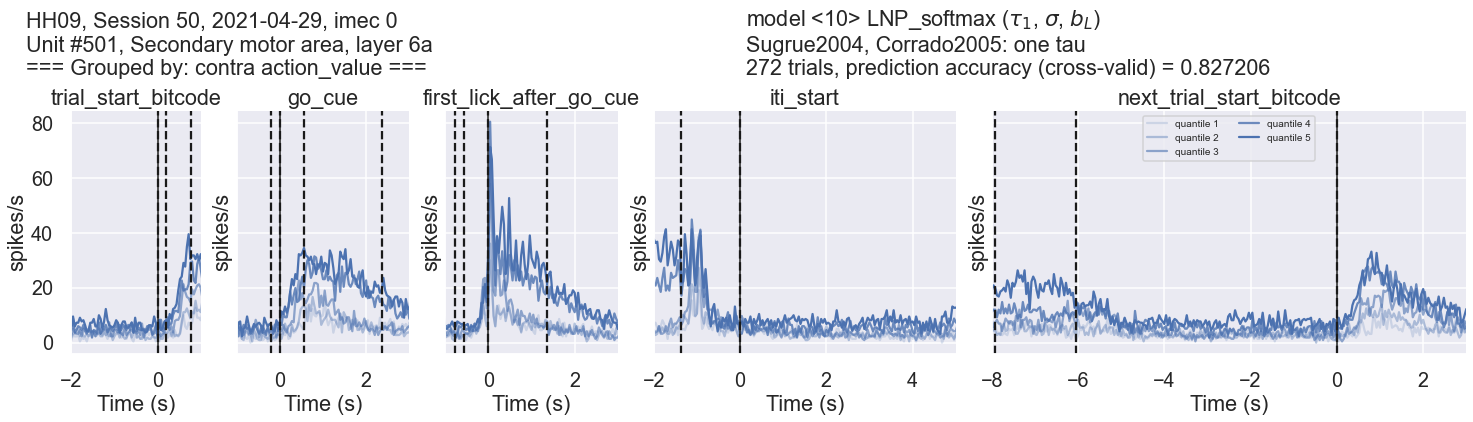

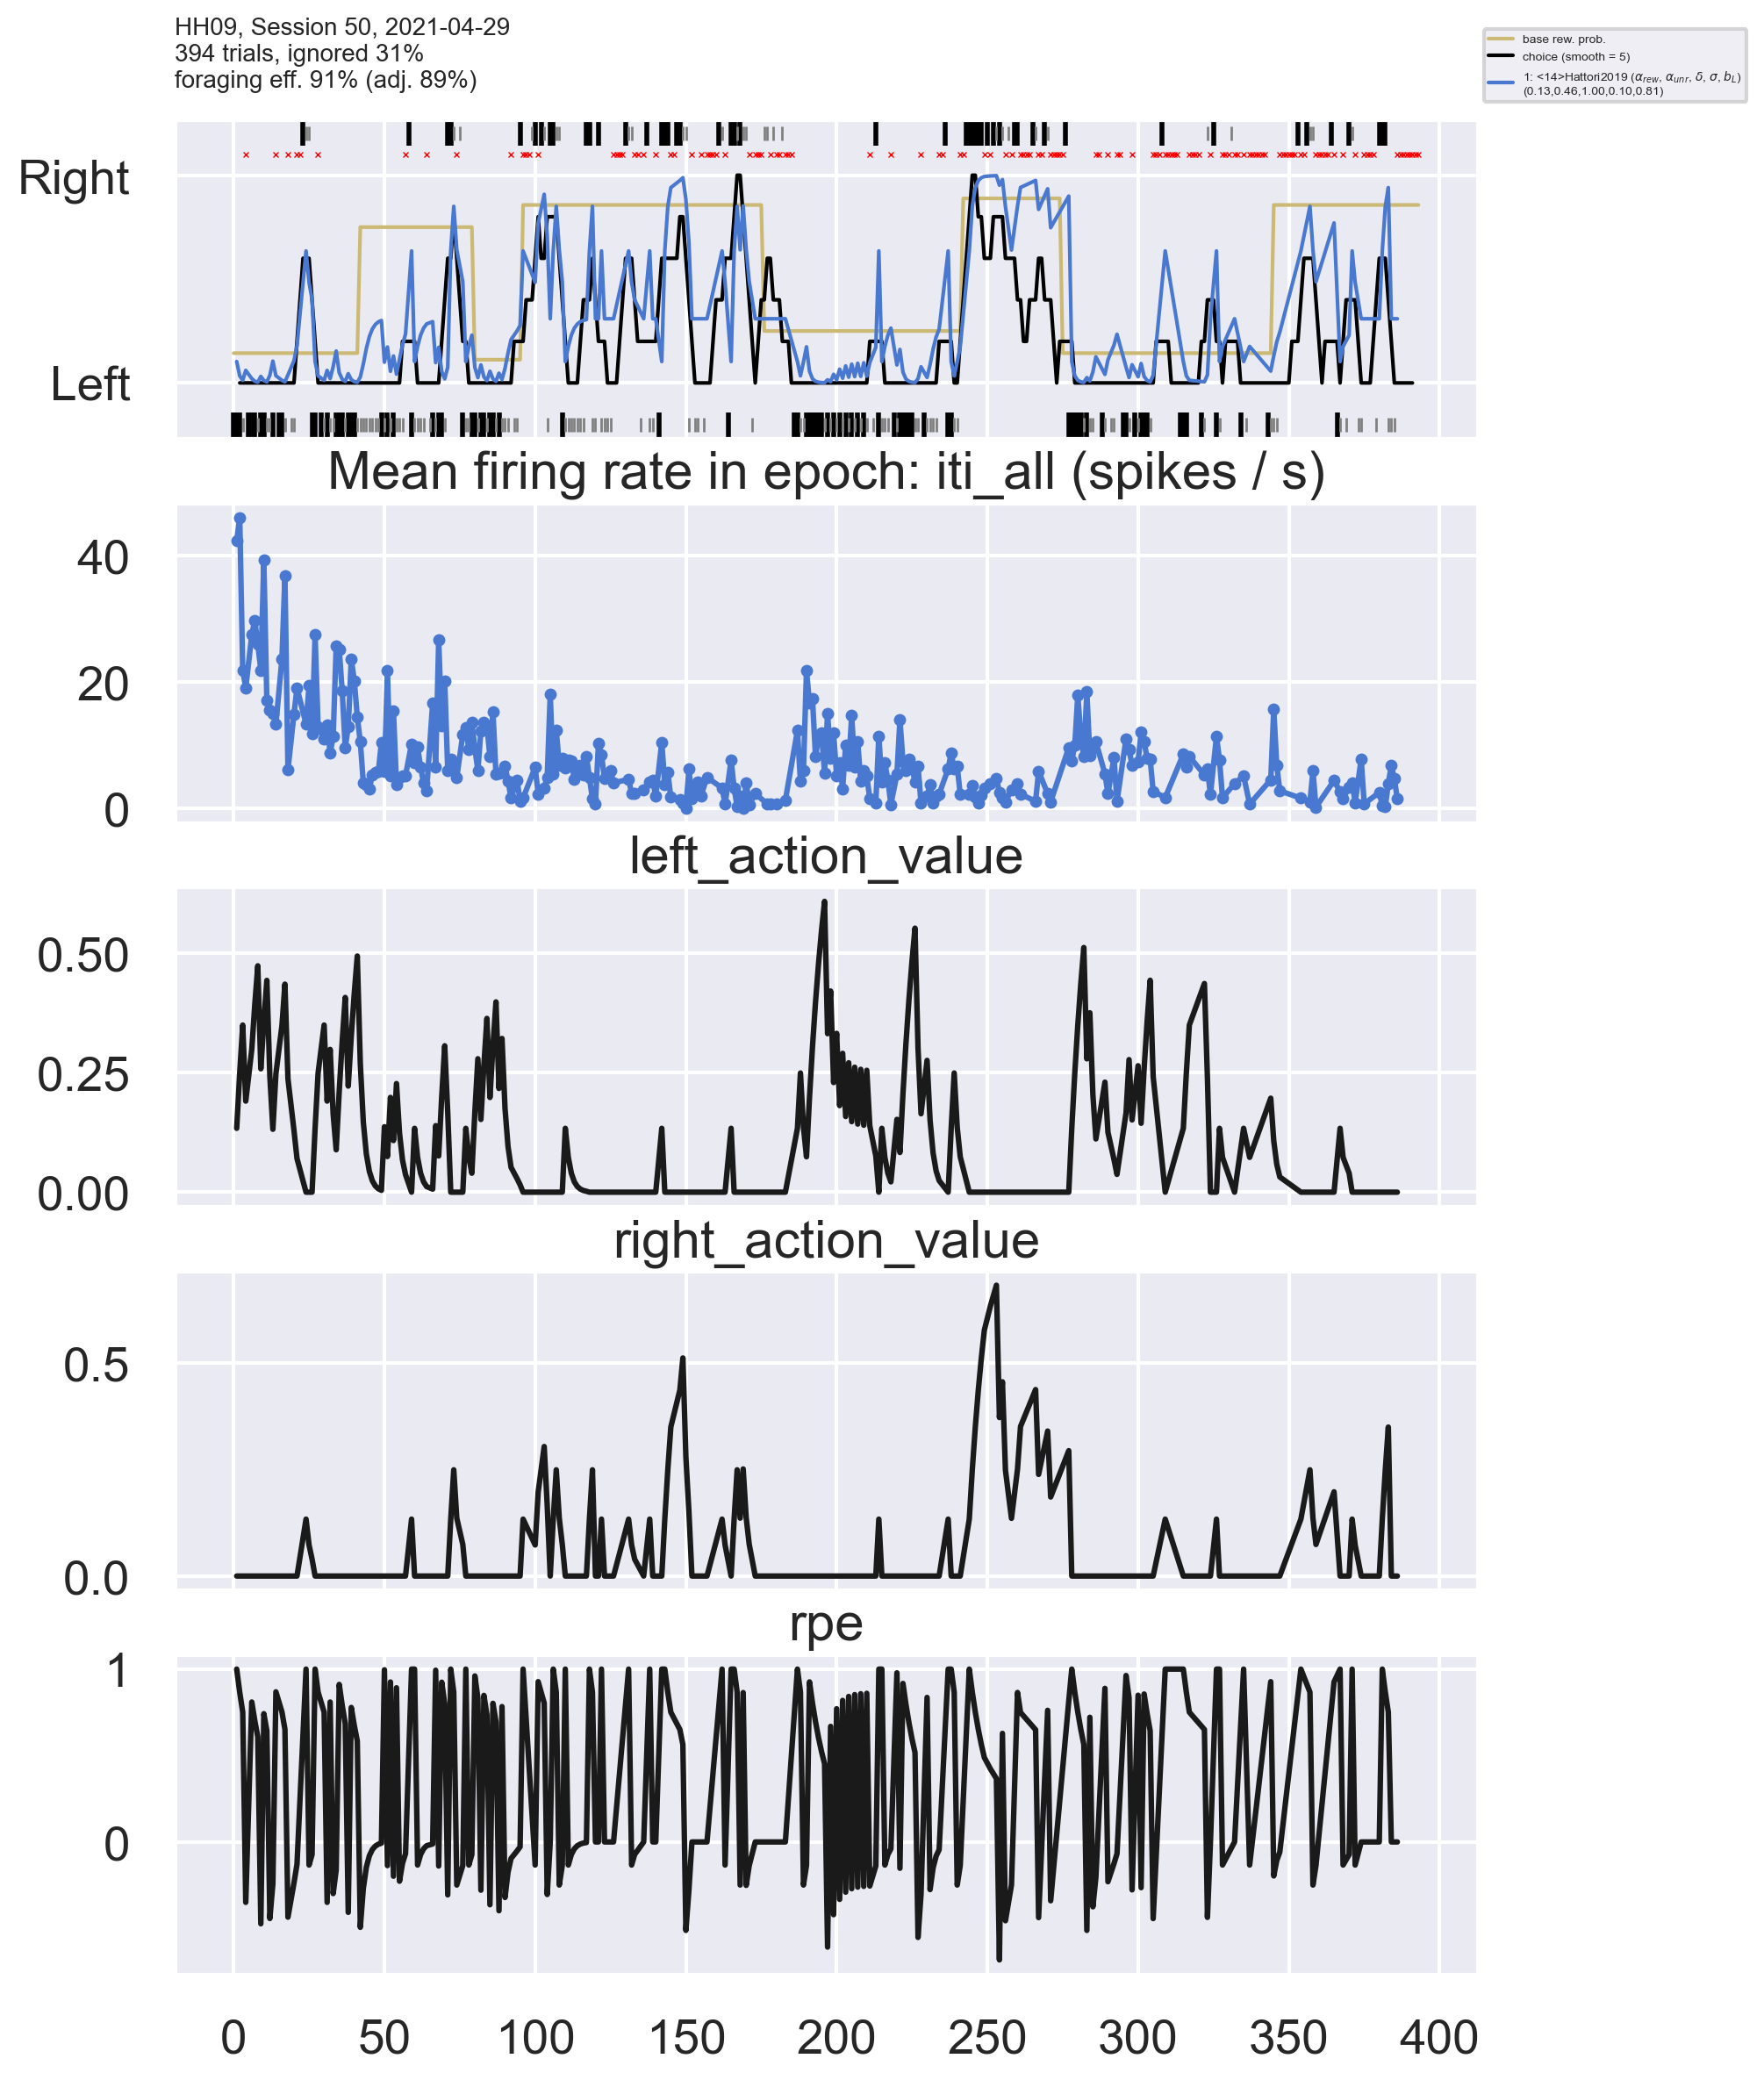

<Figure size 1600x600 with 0 Axes>

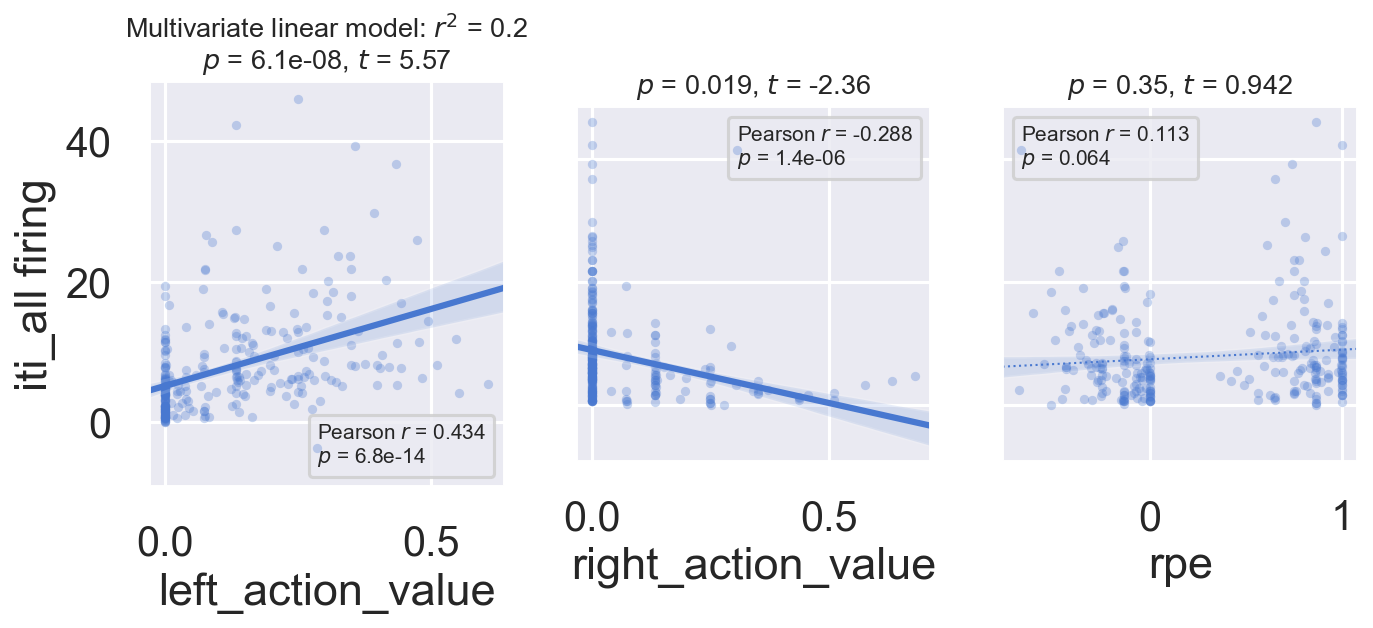

In [14]:
date, imec, unit = '2021-04-29', 0, 501
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)
plot_unit_period_tuning(unit_key)

In [ ]:
date, imec, unit = '2021-04-16', 0, 978
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

In [ ]:
date, imec, unit = '2021-04-29', 1, 362
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10, side='ipsi')

#### Thalamus

In [ ]:
date, imec, unit = '2021-06-11', 1, 75
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

In [ ]:
date, imec, unit = '2021-06-11', 1, 310
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

#### Striatum

In [ ]:
date, imec, unit = '2021-04-29', 0, 113
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10, side='ipsi')

####  Midbrain

These two should be in VTA

(<Figure size 2200x2800 with 5 Axes>, <Figure size 1560x1072.5 with 3 Axes>)

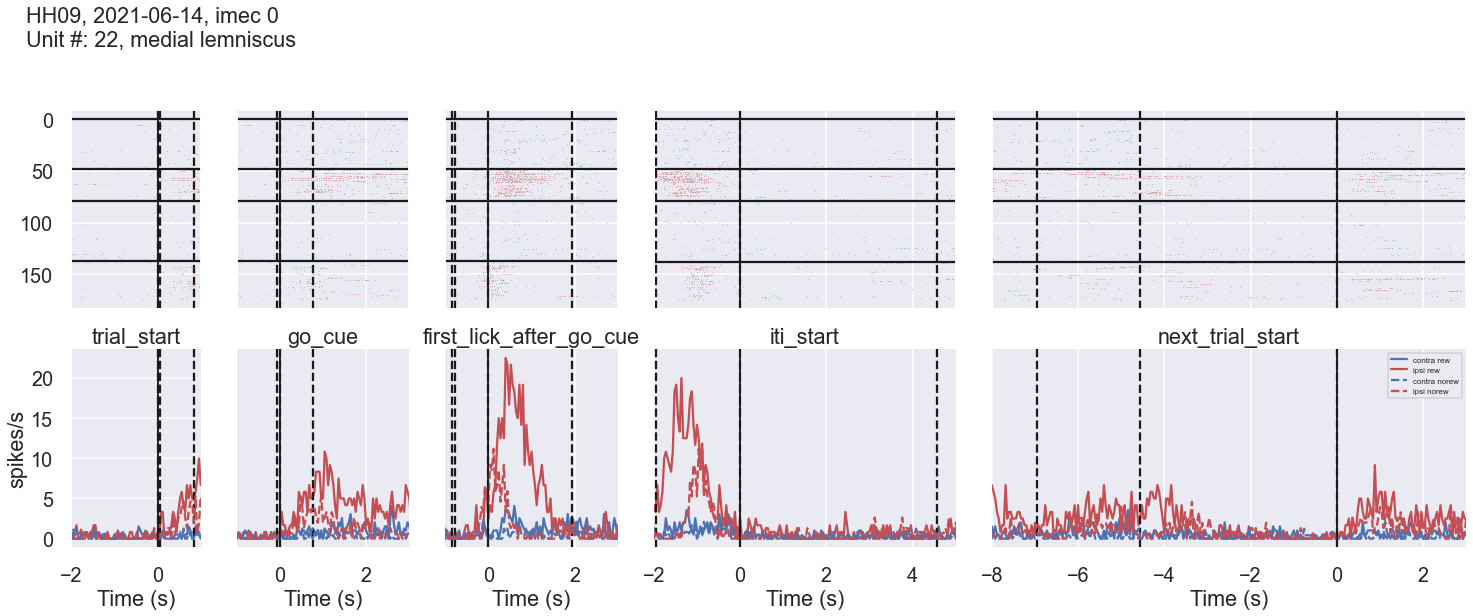

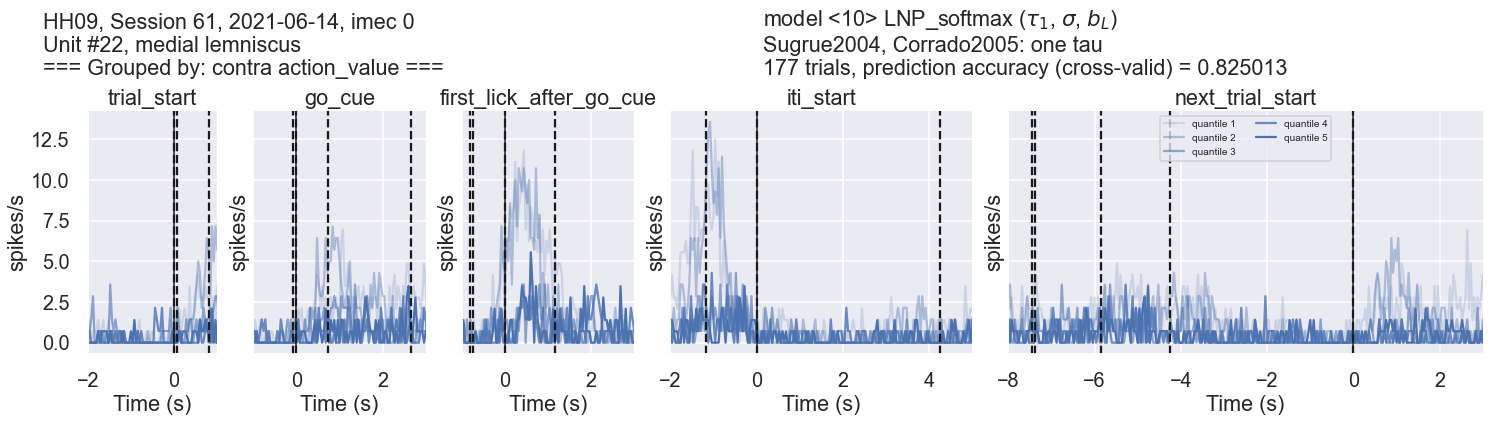

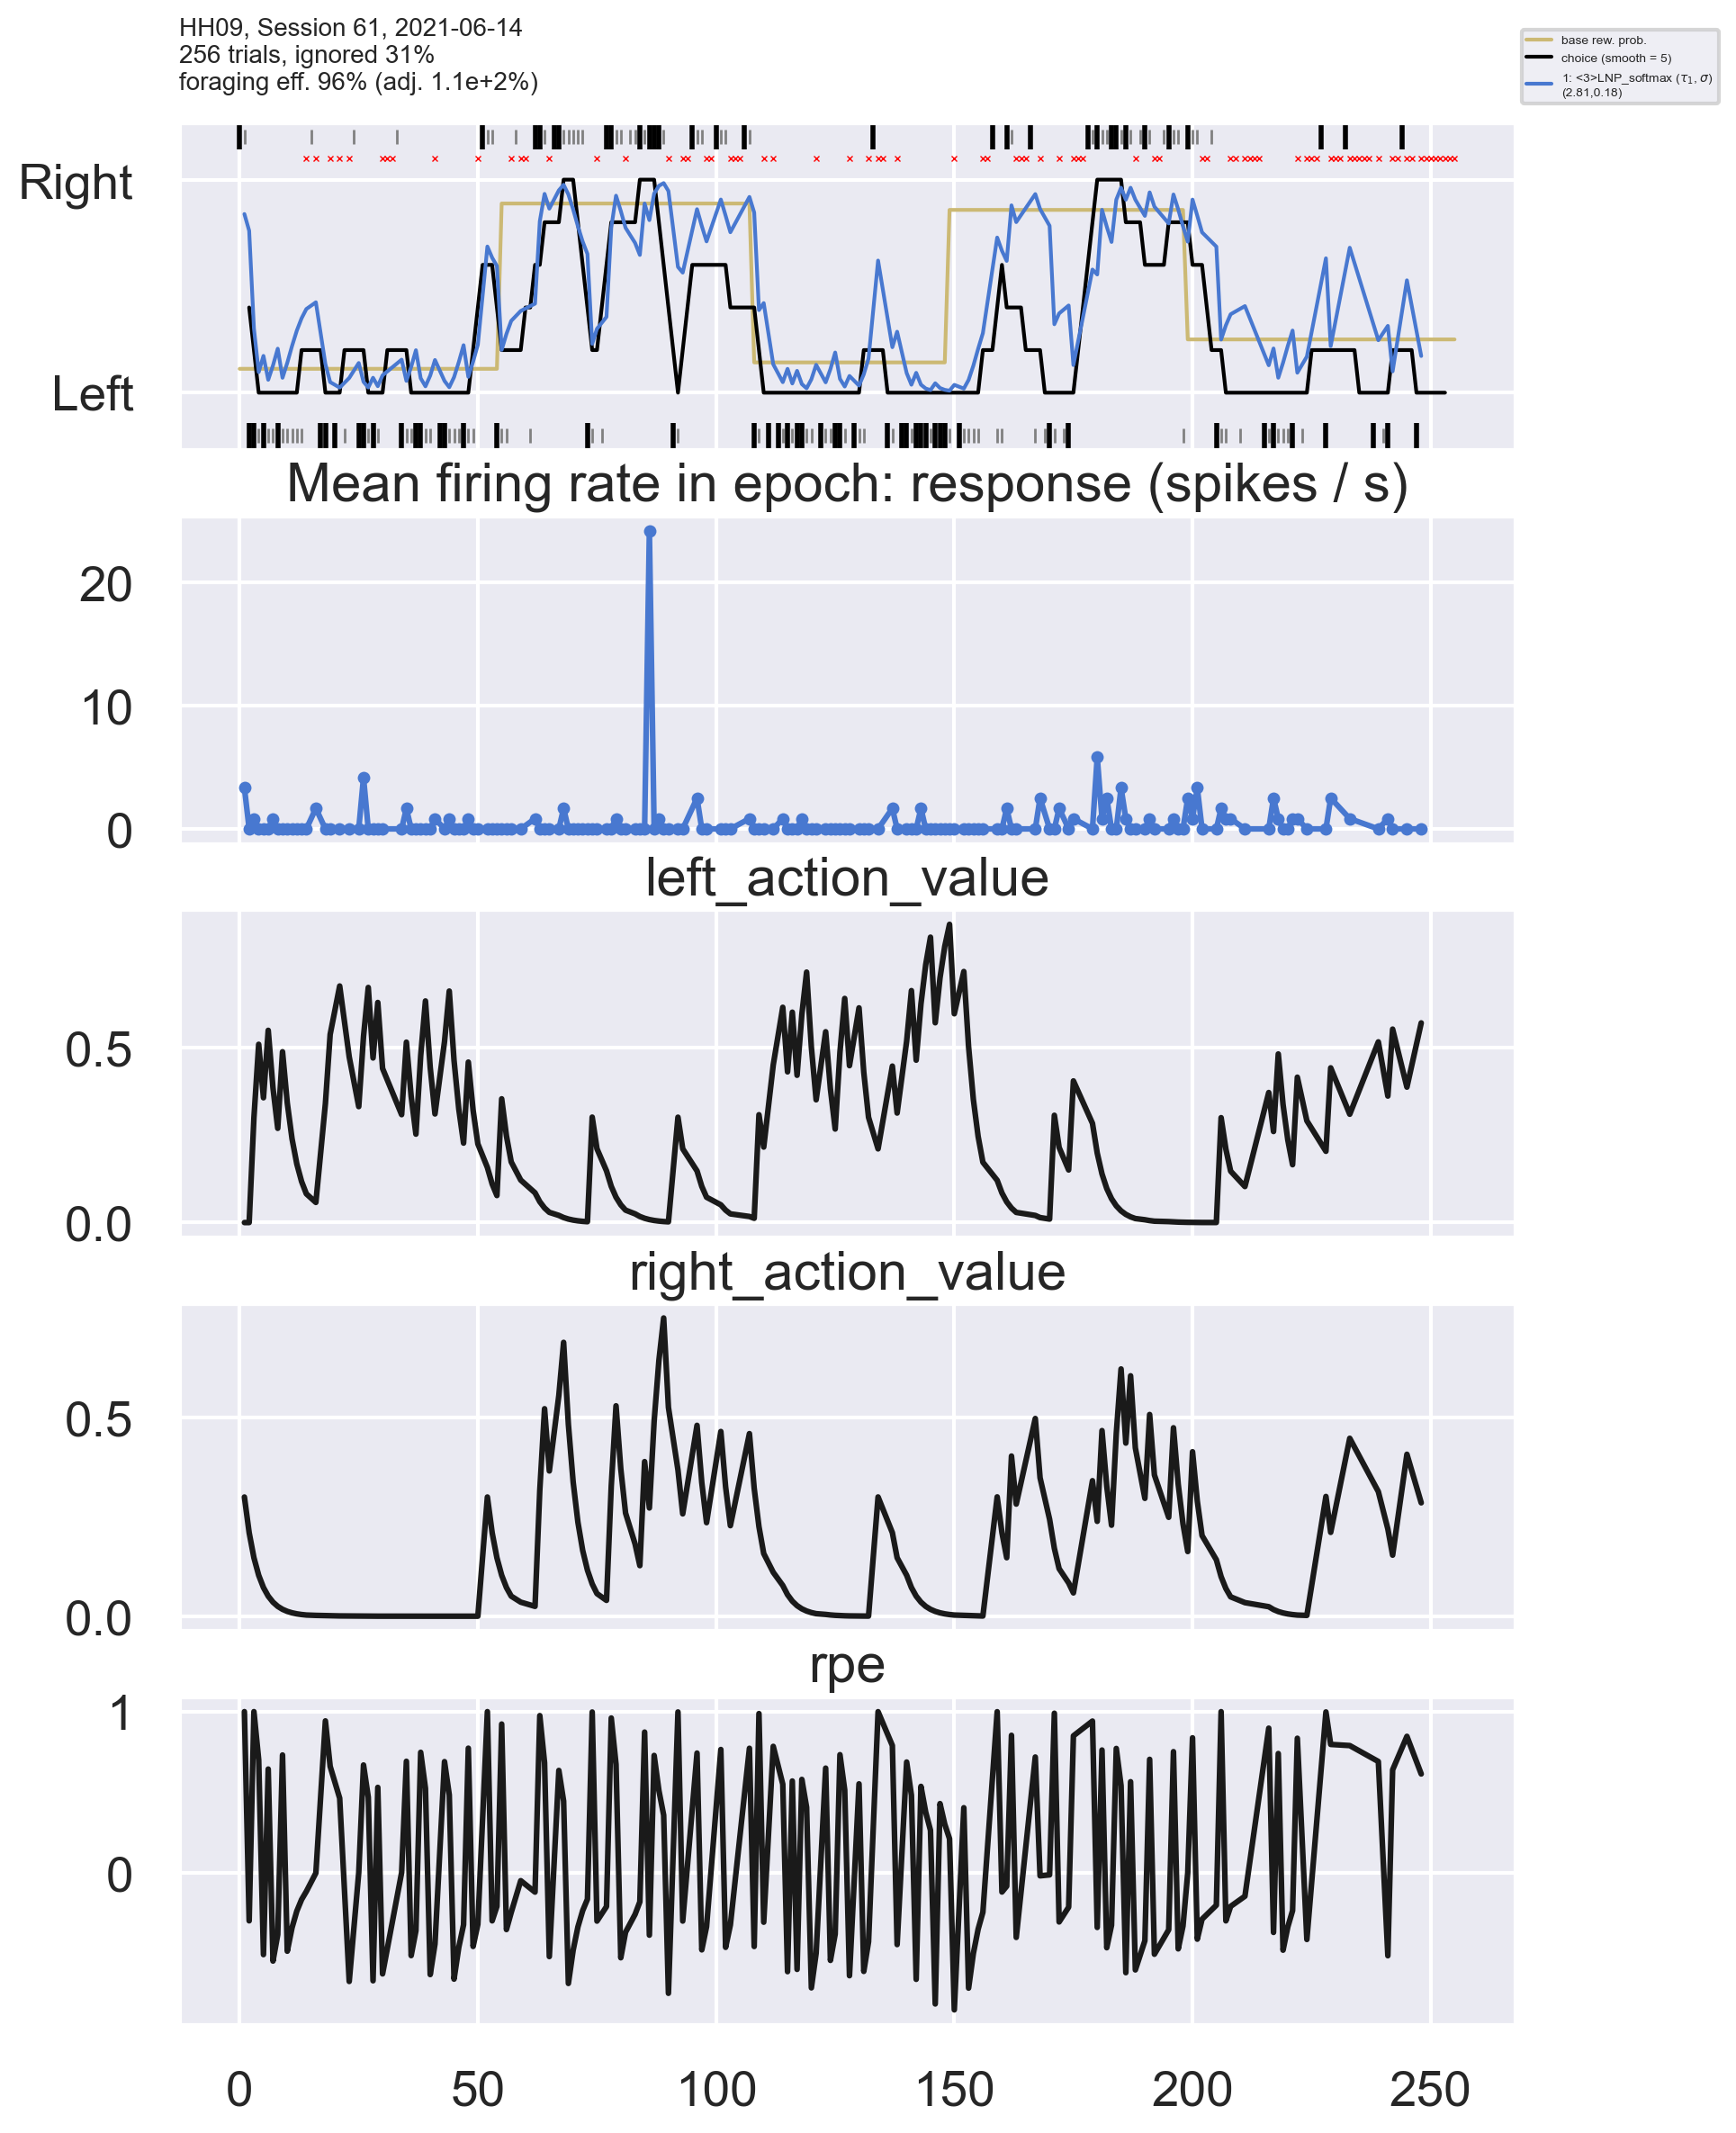

<Figure size 1600x600 with 0 Axes>

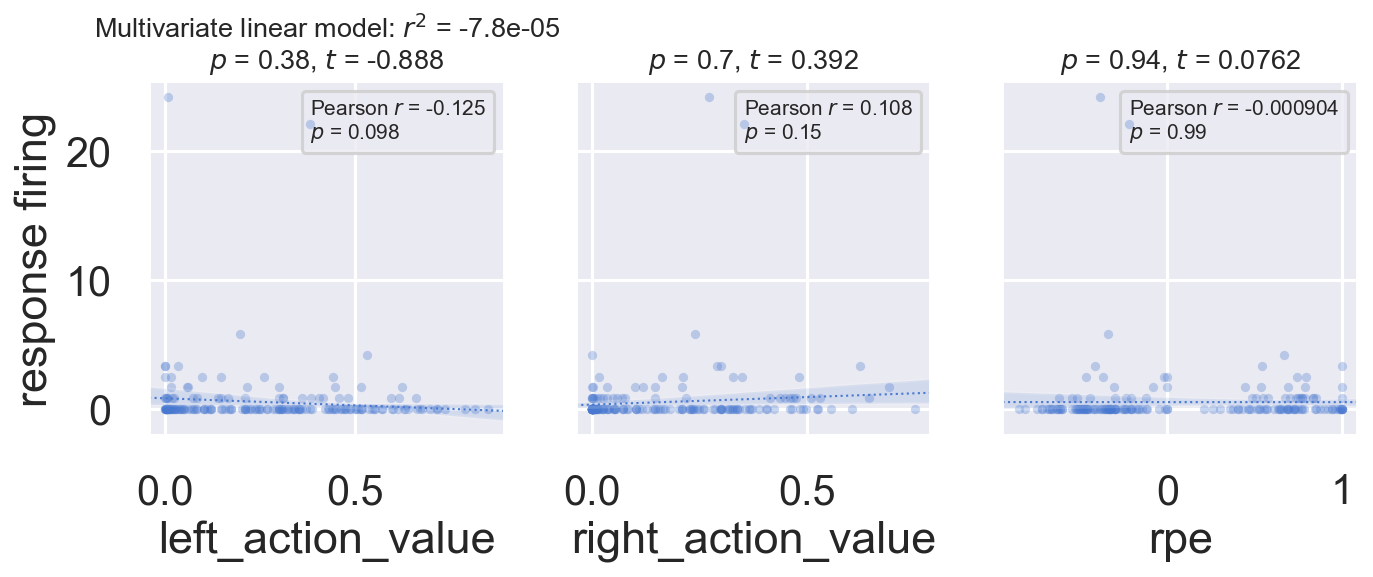

In [18]:
date, imec, unit = '2021-06-14', 0, 22
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)
plot_unit_period_tuning(unit_key, period='response')

(<Figure size 2200x2800 with 5 Axes>, <Figure size 1560x1072.5 with 3 Axes>)

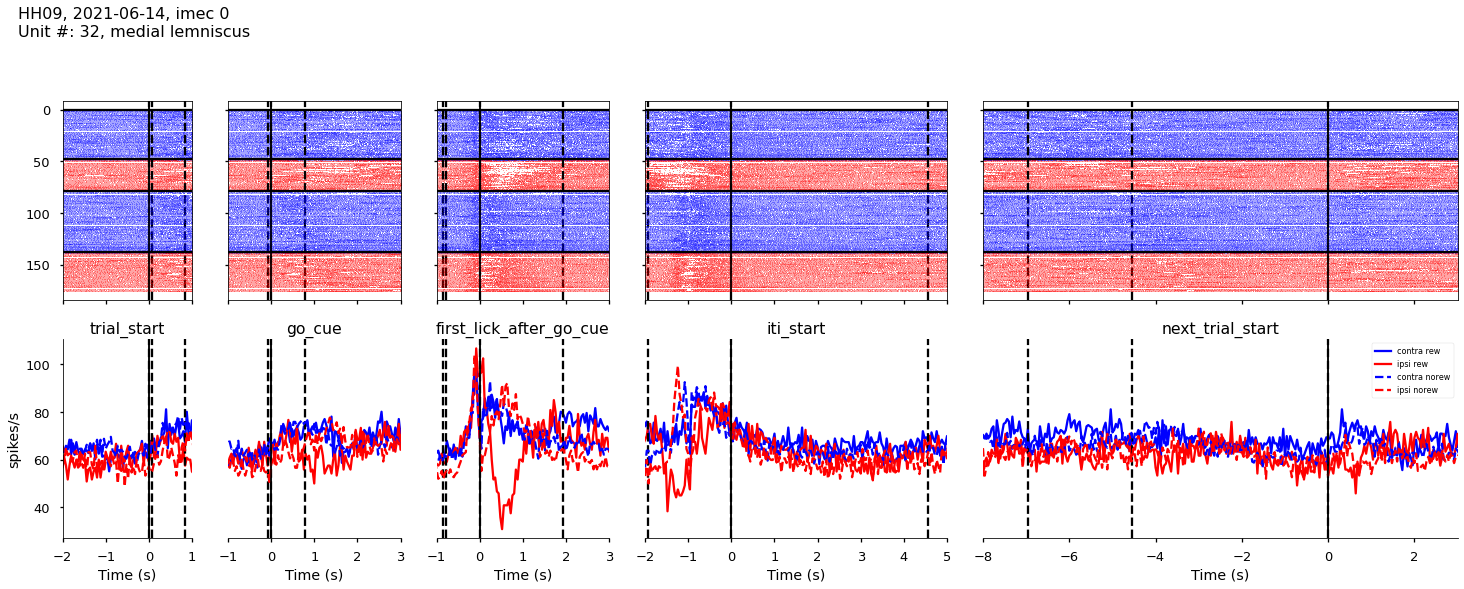

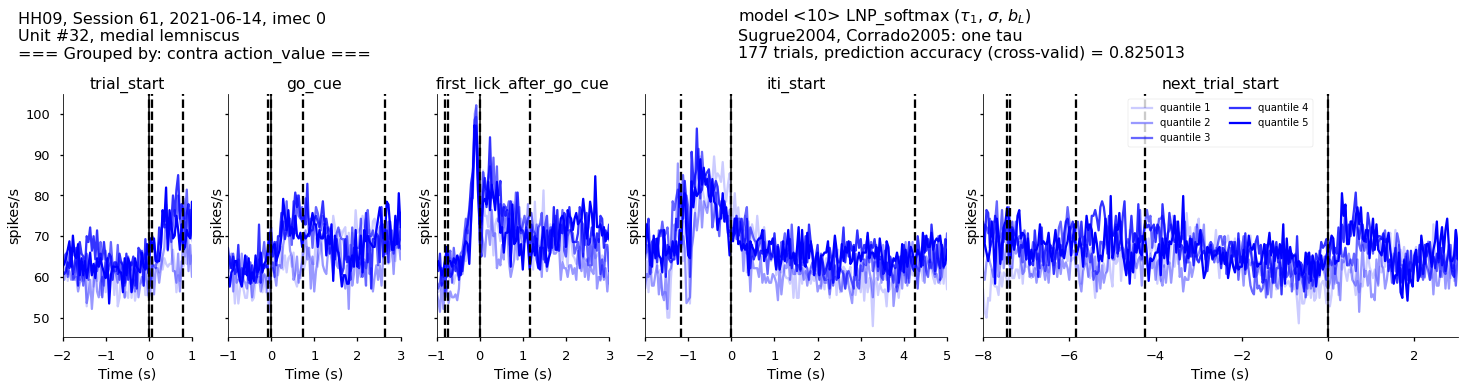

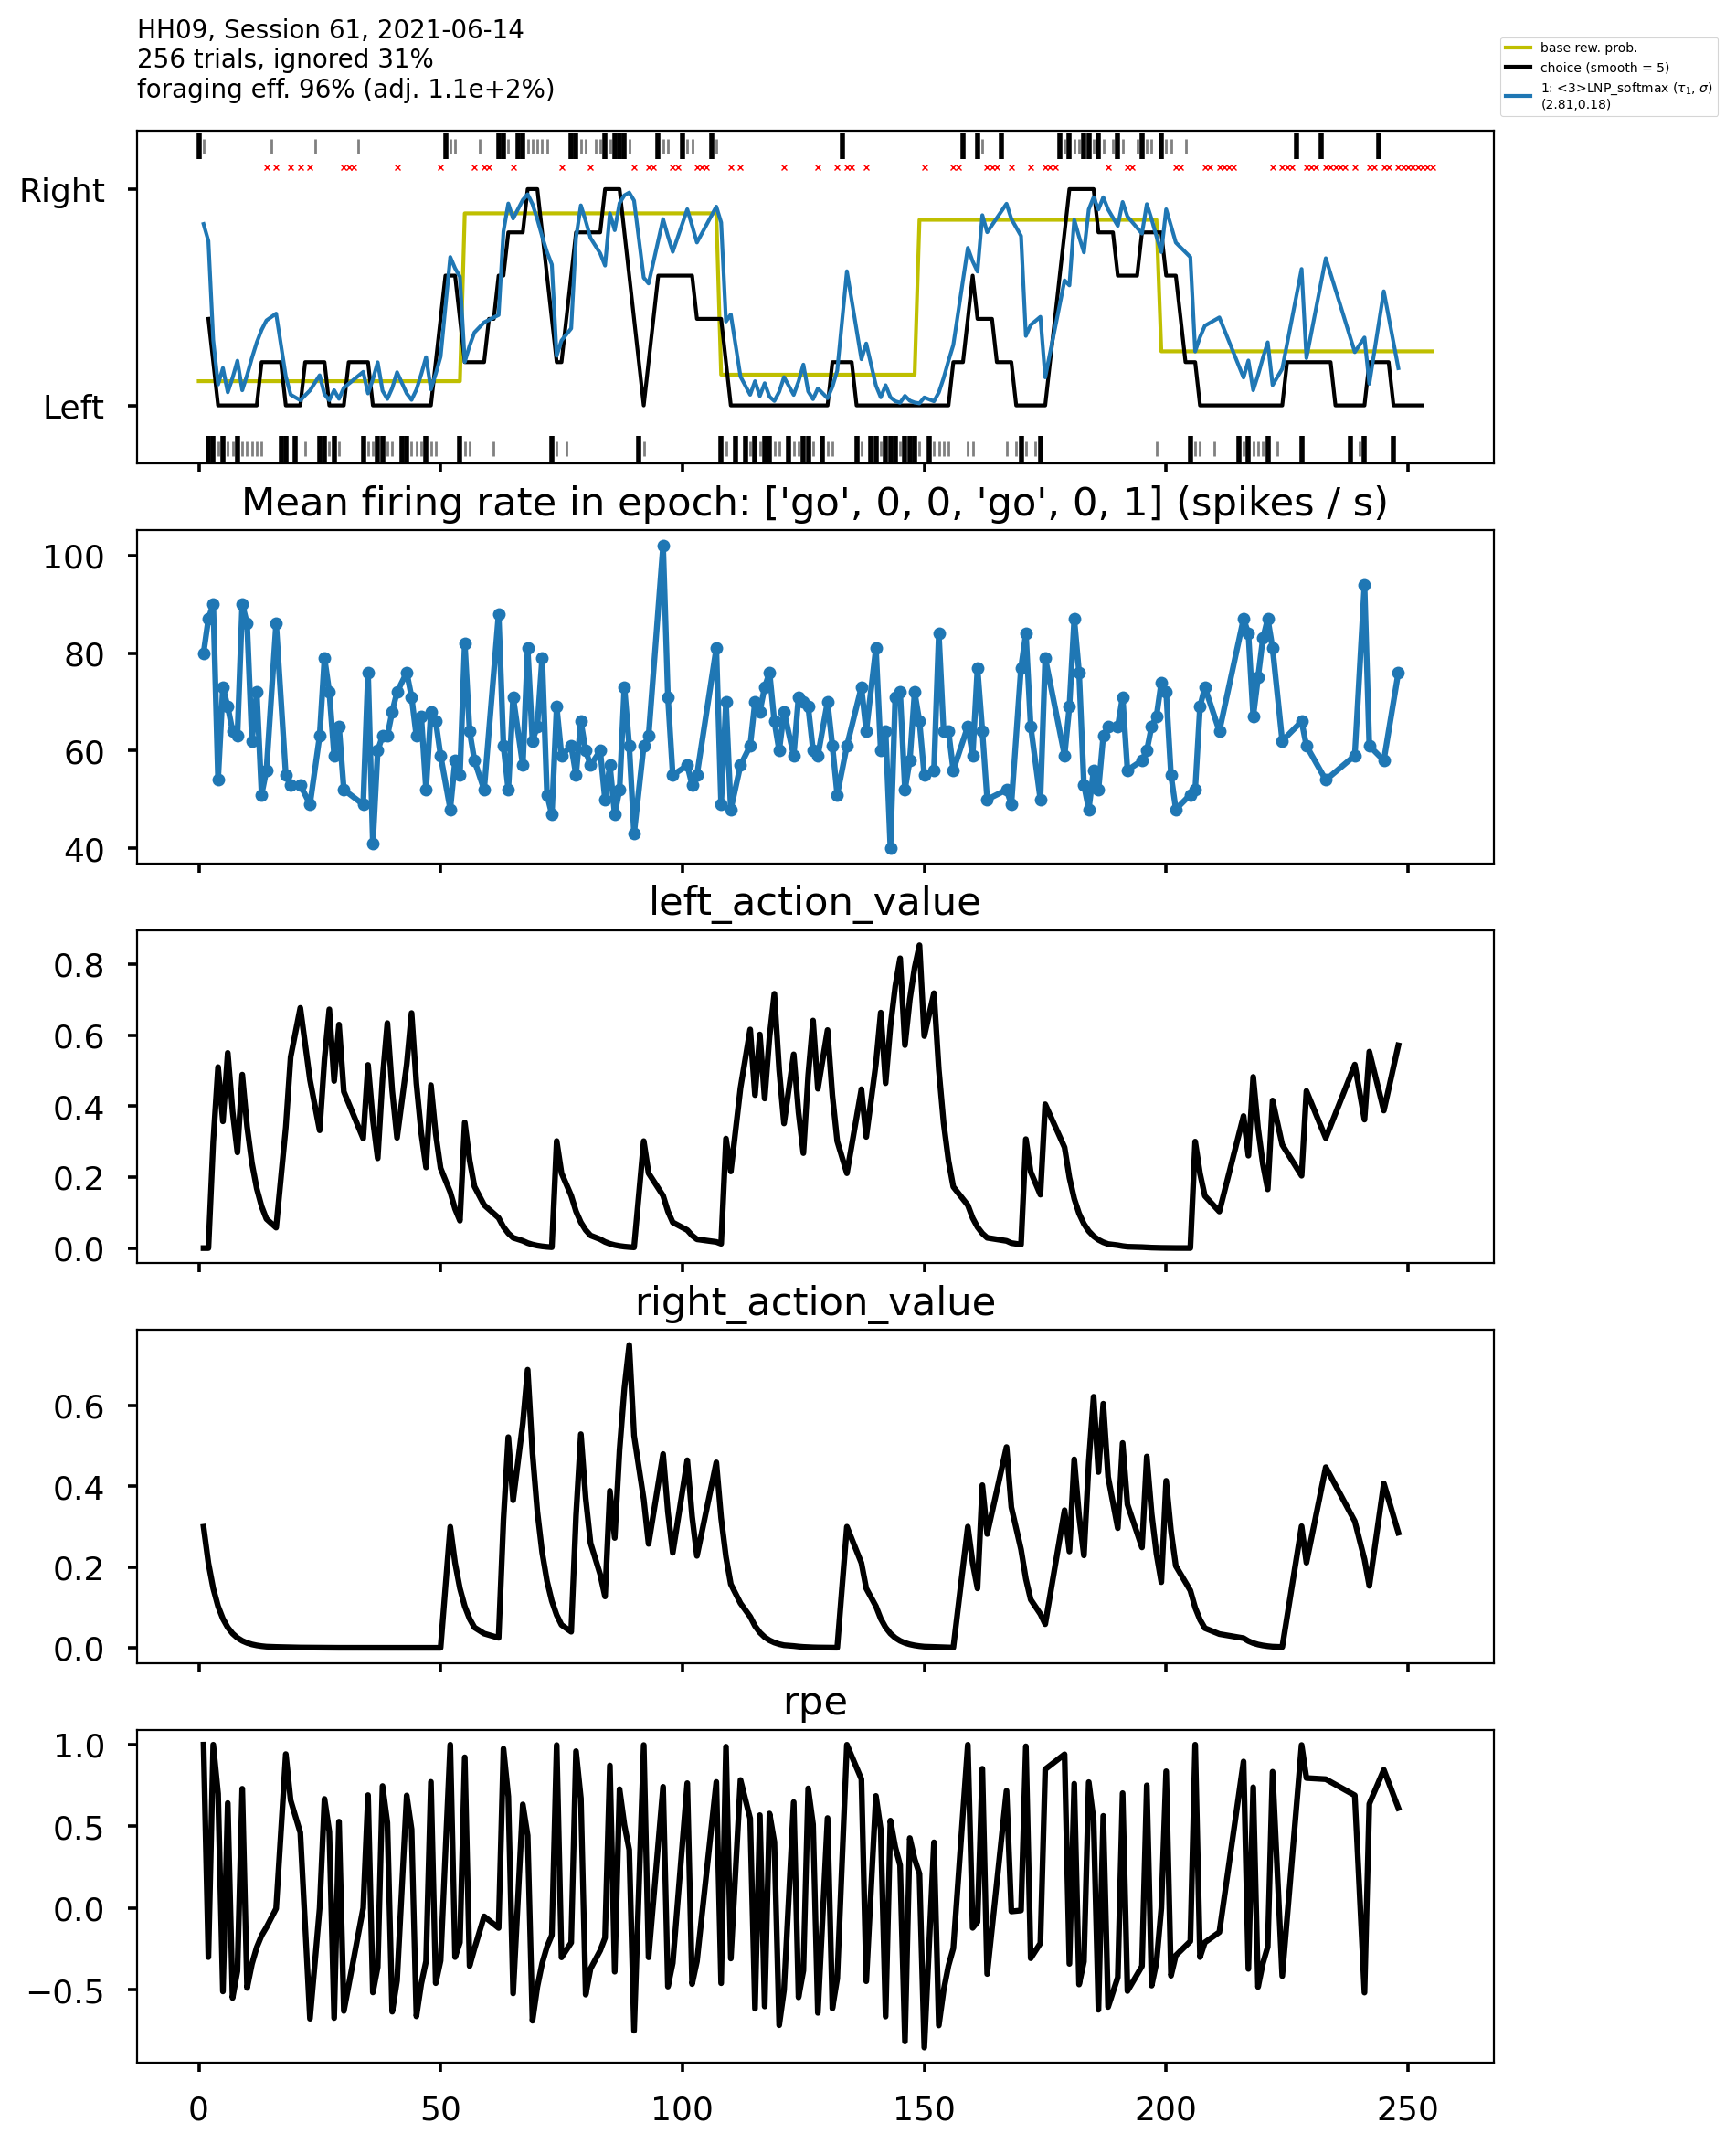

<Figure size 1600x600 with 0 Axes>

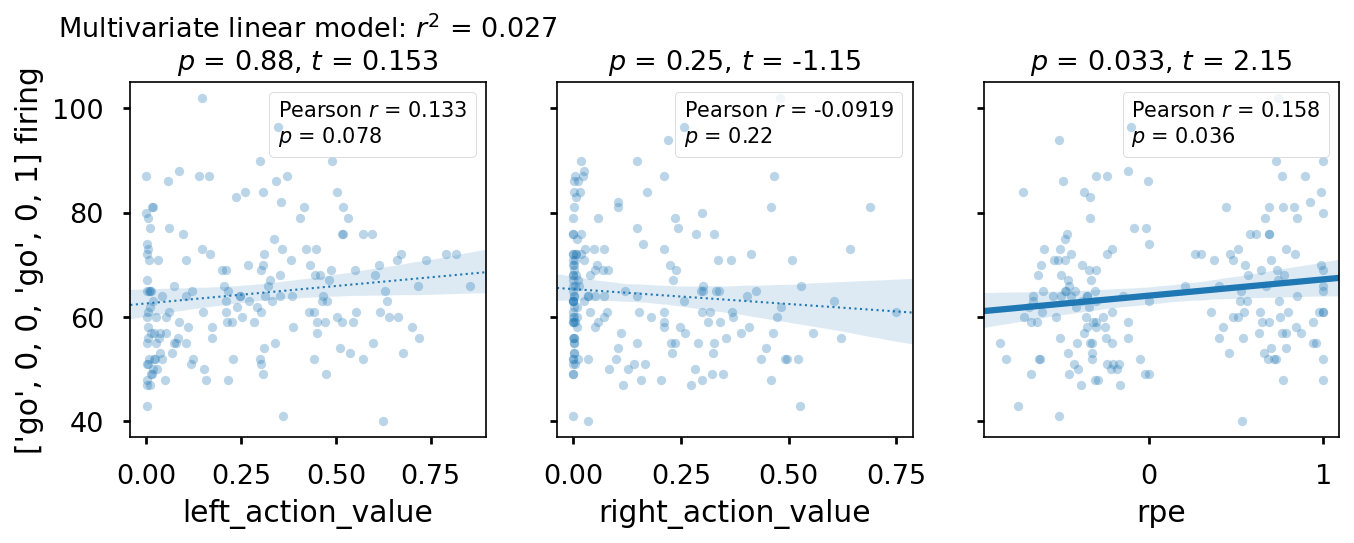

In [6]:
date, imec, unit = '2021-06-14', 0, 32
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)
plot_unit_period_tuning(unit_key, period=['go', 0, 0, 'go', 0, 1]) # ['go', 0, 0, 'go', 0, 1])

#### Ventral Pallidum

(<Figure size 2200x2800 with 5 Axes>, <Figure size 1560x1072.5 with 3 Axes>)

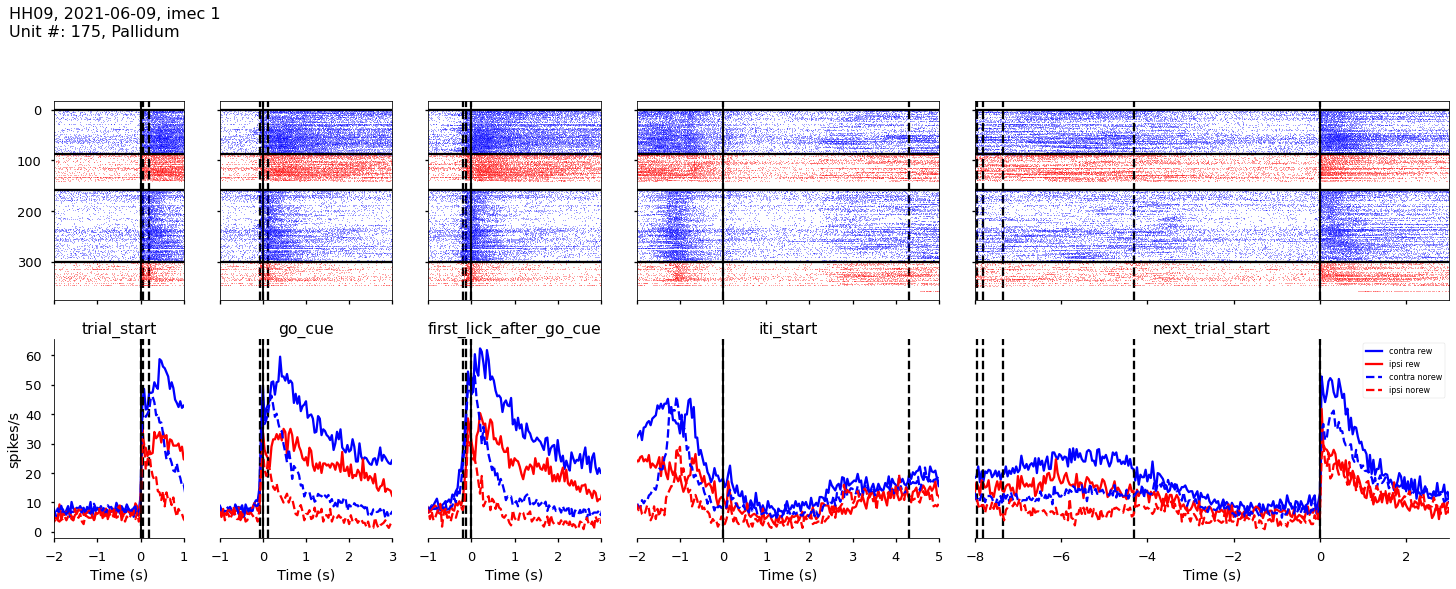

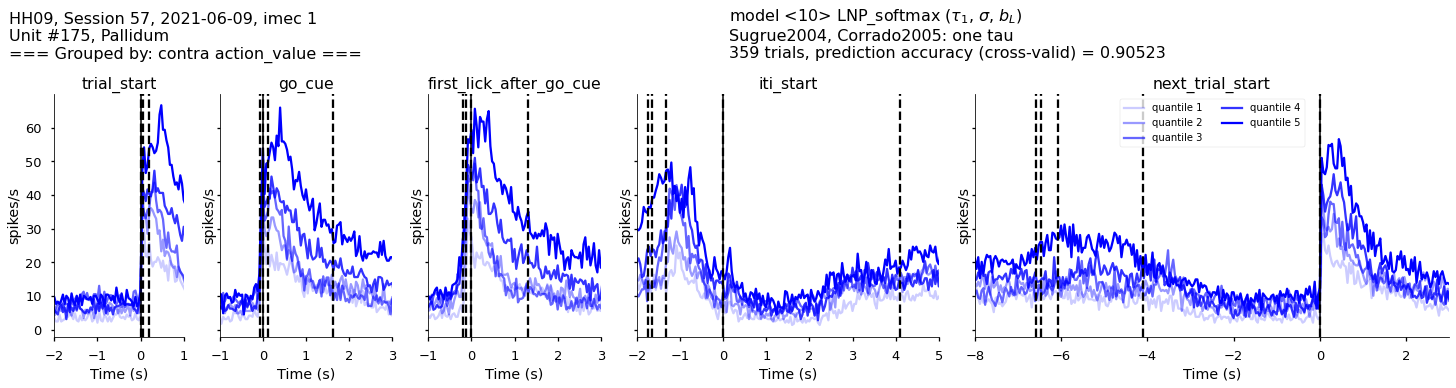

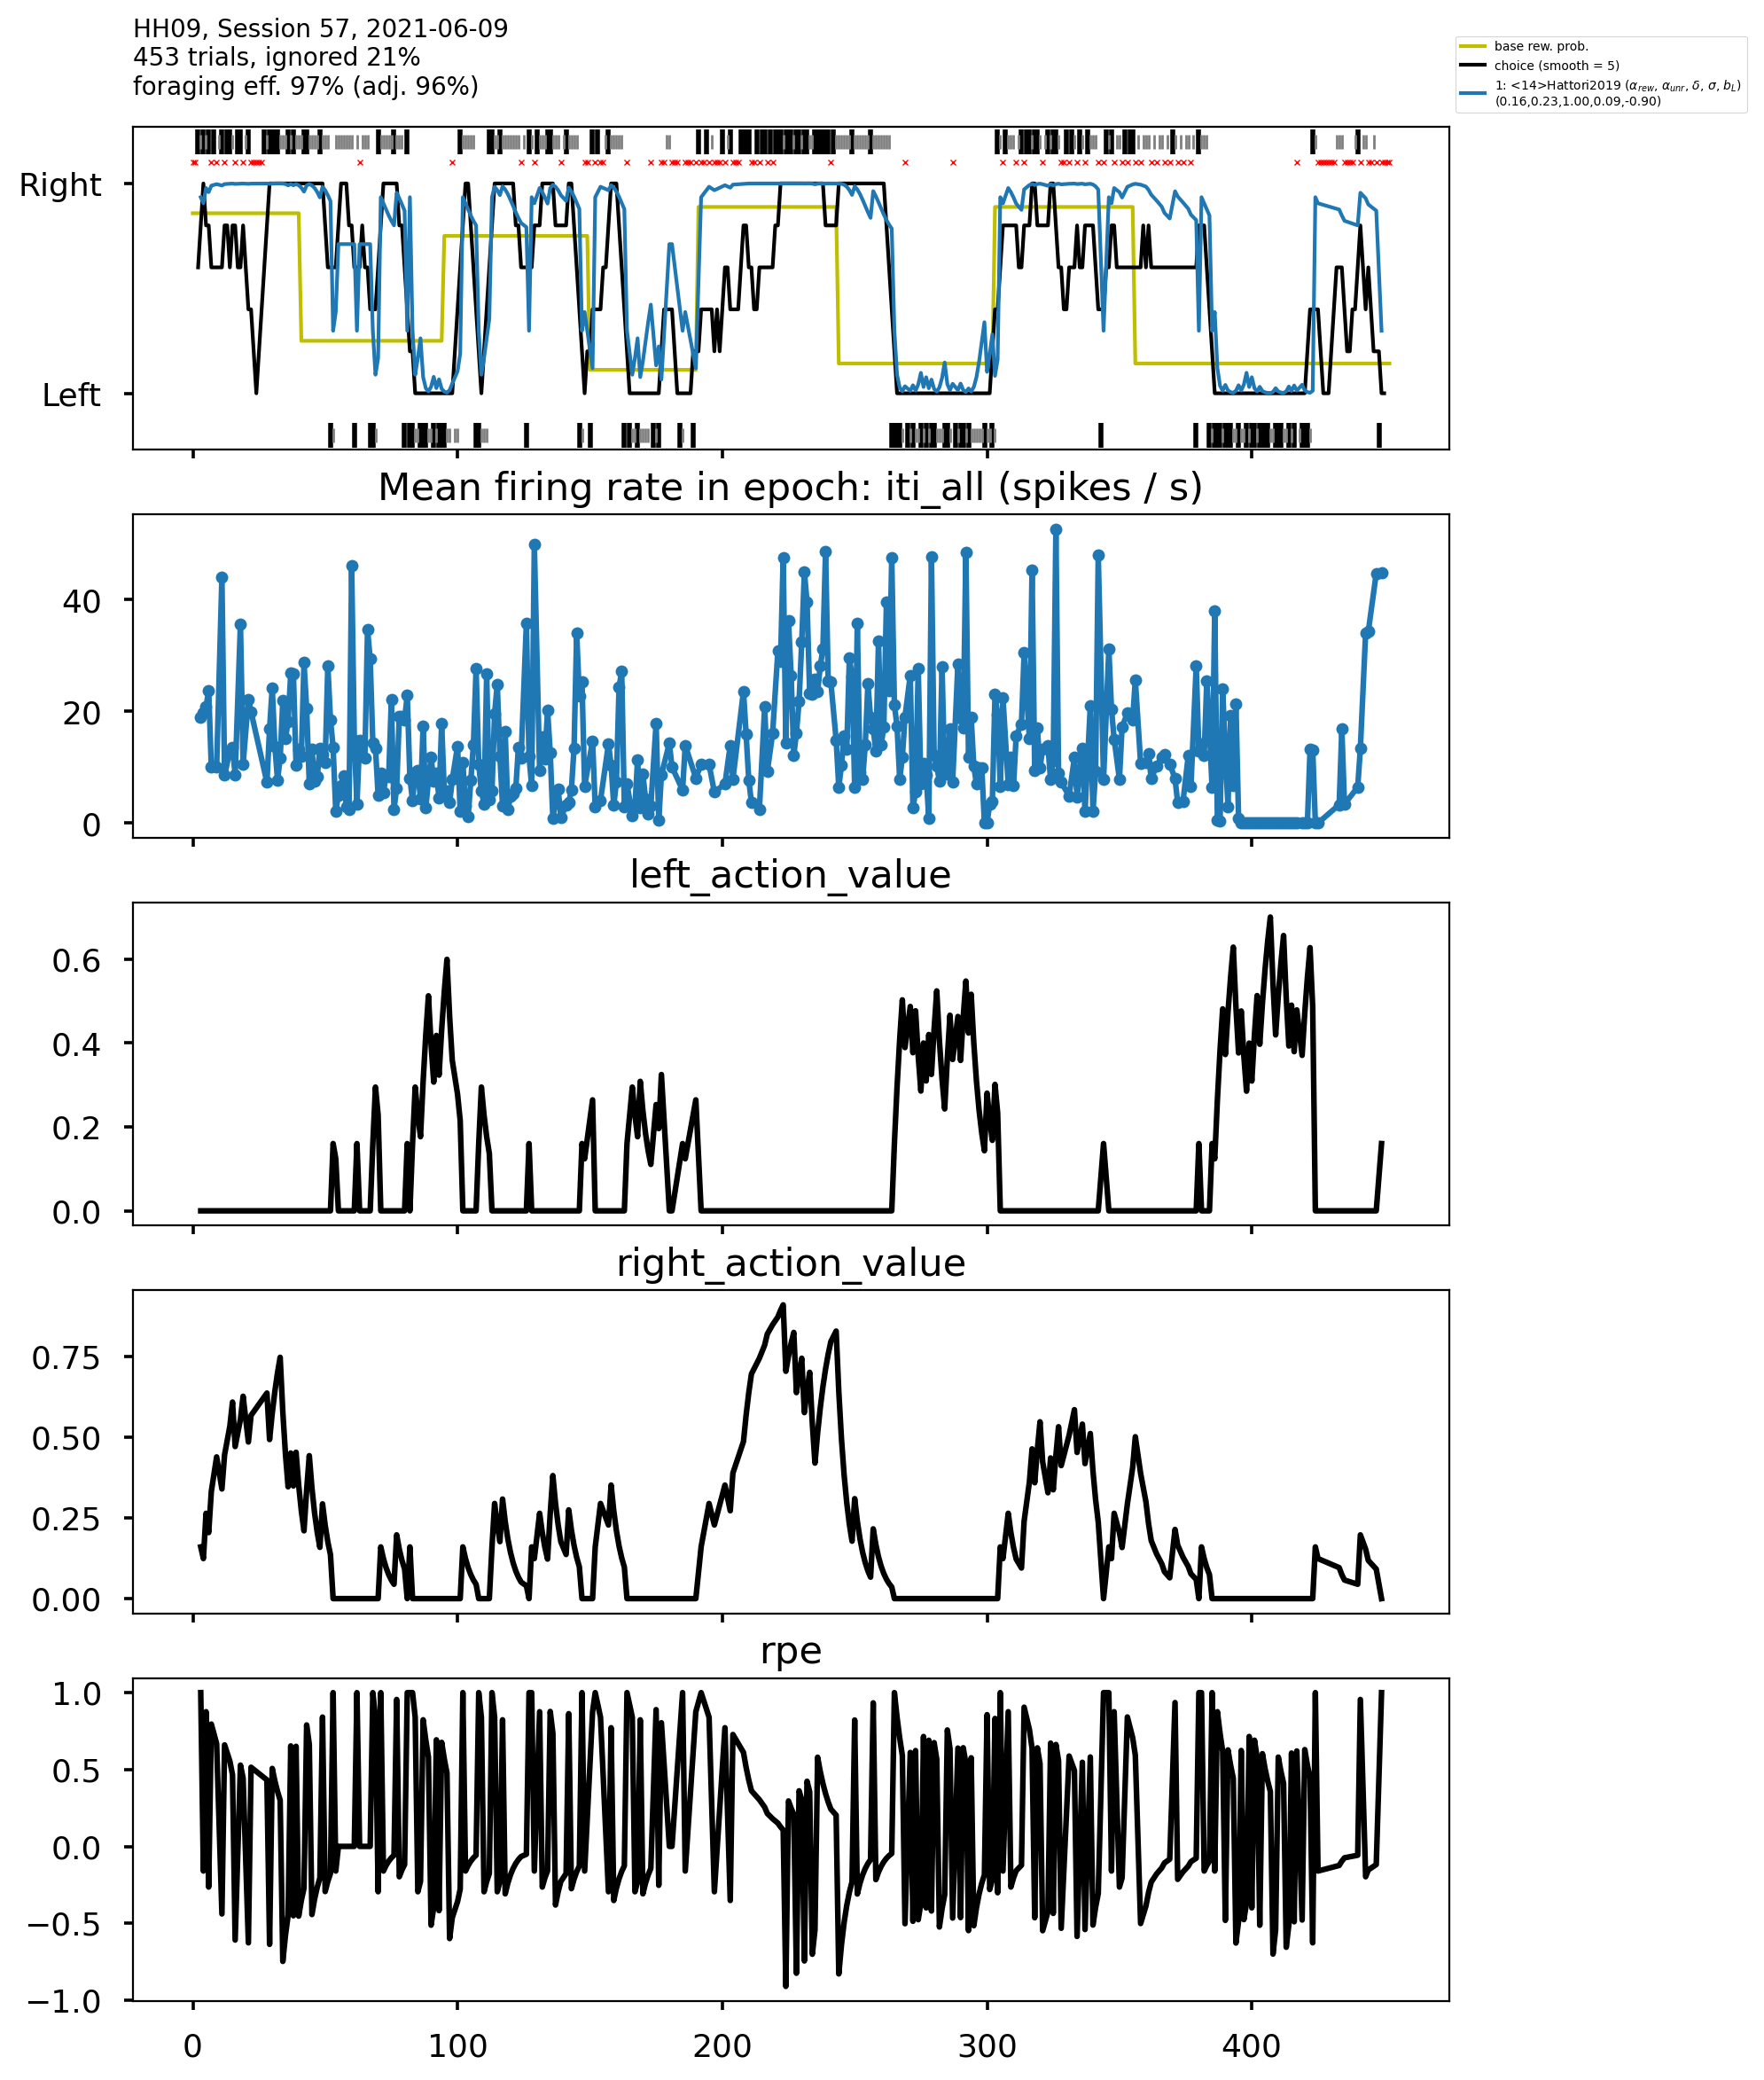

<Figure size 1600x600 with 0 Axes>

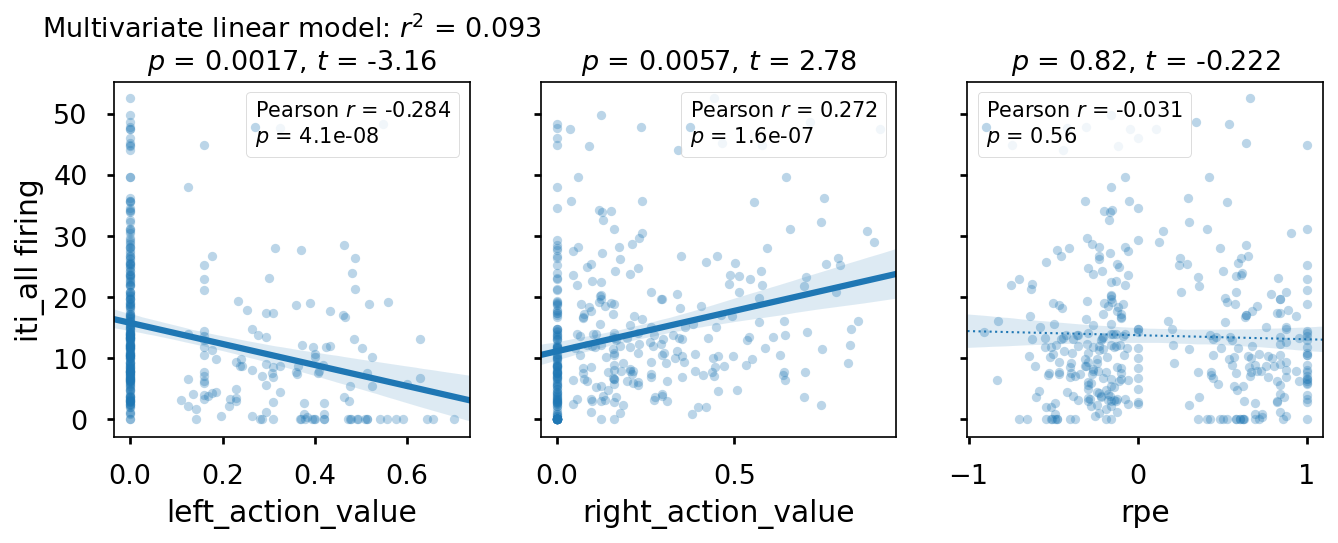

In [10]:
date, imec, unit = '2021-06-09', 1, 175
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)
plot_unit_period_tuning(unit_key, period='iti_all') # ['go', 0, 0, 'go', 0, 1])

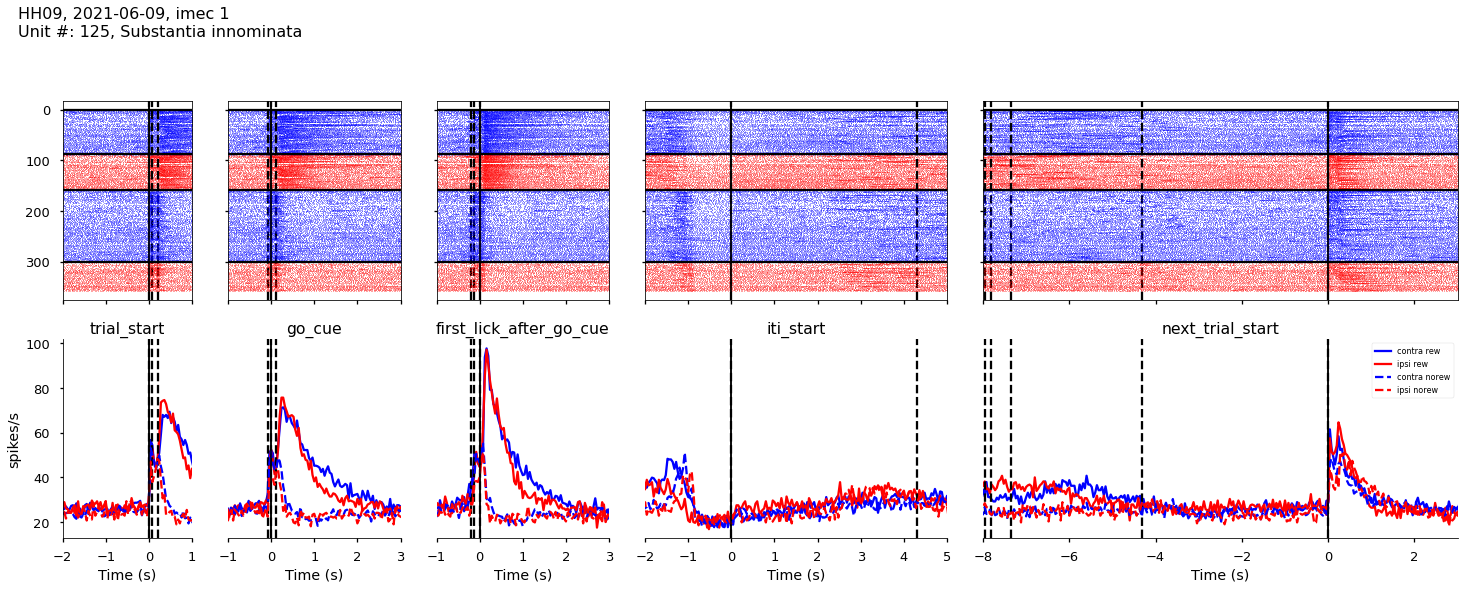

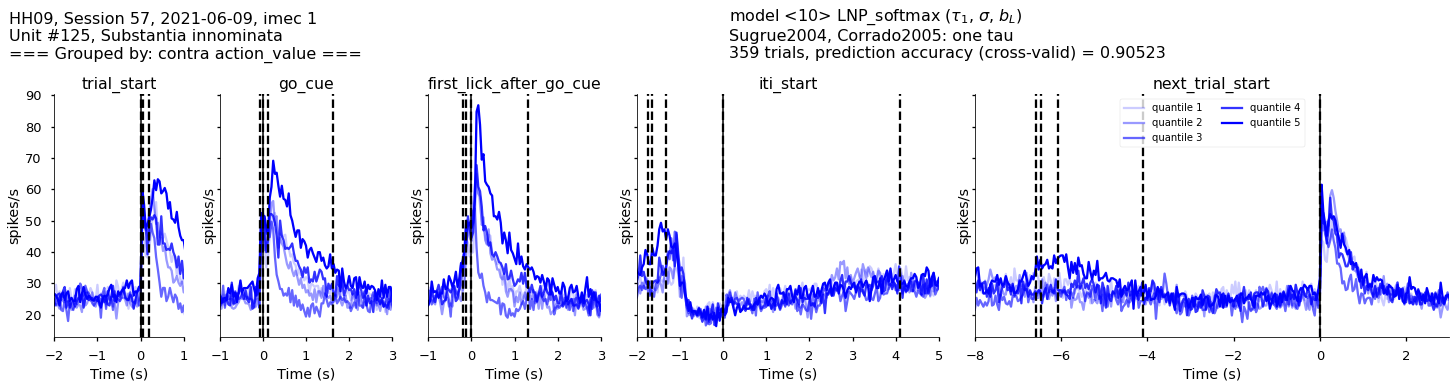

In [11]:
date, imec, unit = '2021-06-09', 1, 125
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

#### RSC

In [ ]:
date, imec, unit = '2021-06-12', 0, 168
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

#### OFC

In [ ]:
date, imec, unit = '2021-04-29', 0, 299
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

# Unit selectivity 

## Preparation

In [ ]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() * experiment.Session & {'session_date': date, 'subject_id': 473361, 'insertion_number':imec + 1, 'unit_uid': unit}).fetch1("KEY")

Neural activity per trial (given unit, period)

In [8]:
from pipeline.psth_foraging import compute_unit_period_activity
from pipeline.util import _get_unit_independent_variable
from pipeline.plot.foraging_model_plot import plot_session_fitted_choice
from pipeline.plot.unit_psth import plot_unit_period_tuning

In [ ]:
period_activity = compute_unit_period_activity(unit_key, 'iti_all')

Relative value of best model per trial

In [ ]:
best_model = (foraging_model.FittedSessionModelComparison.BestModel & unit_key & 'model_comparison_idx=0').fetch1('best_aic')
lv = _get_unit_independent_variable(unit_key, model_id=best_model)

In [ ]:
trial, relative_value, left_value, right_value, rpe = lv.trial, lv.relative_action_value_ic, lv.left_action_value, lv.right_action_value, lv.rpe
firing = period_activity['firing_rates'][trial-1]

(<Figure size 2200x2800 with 5 Axes>, <Figure size 1560x1072.5 with 3 Axes>)

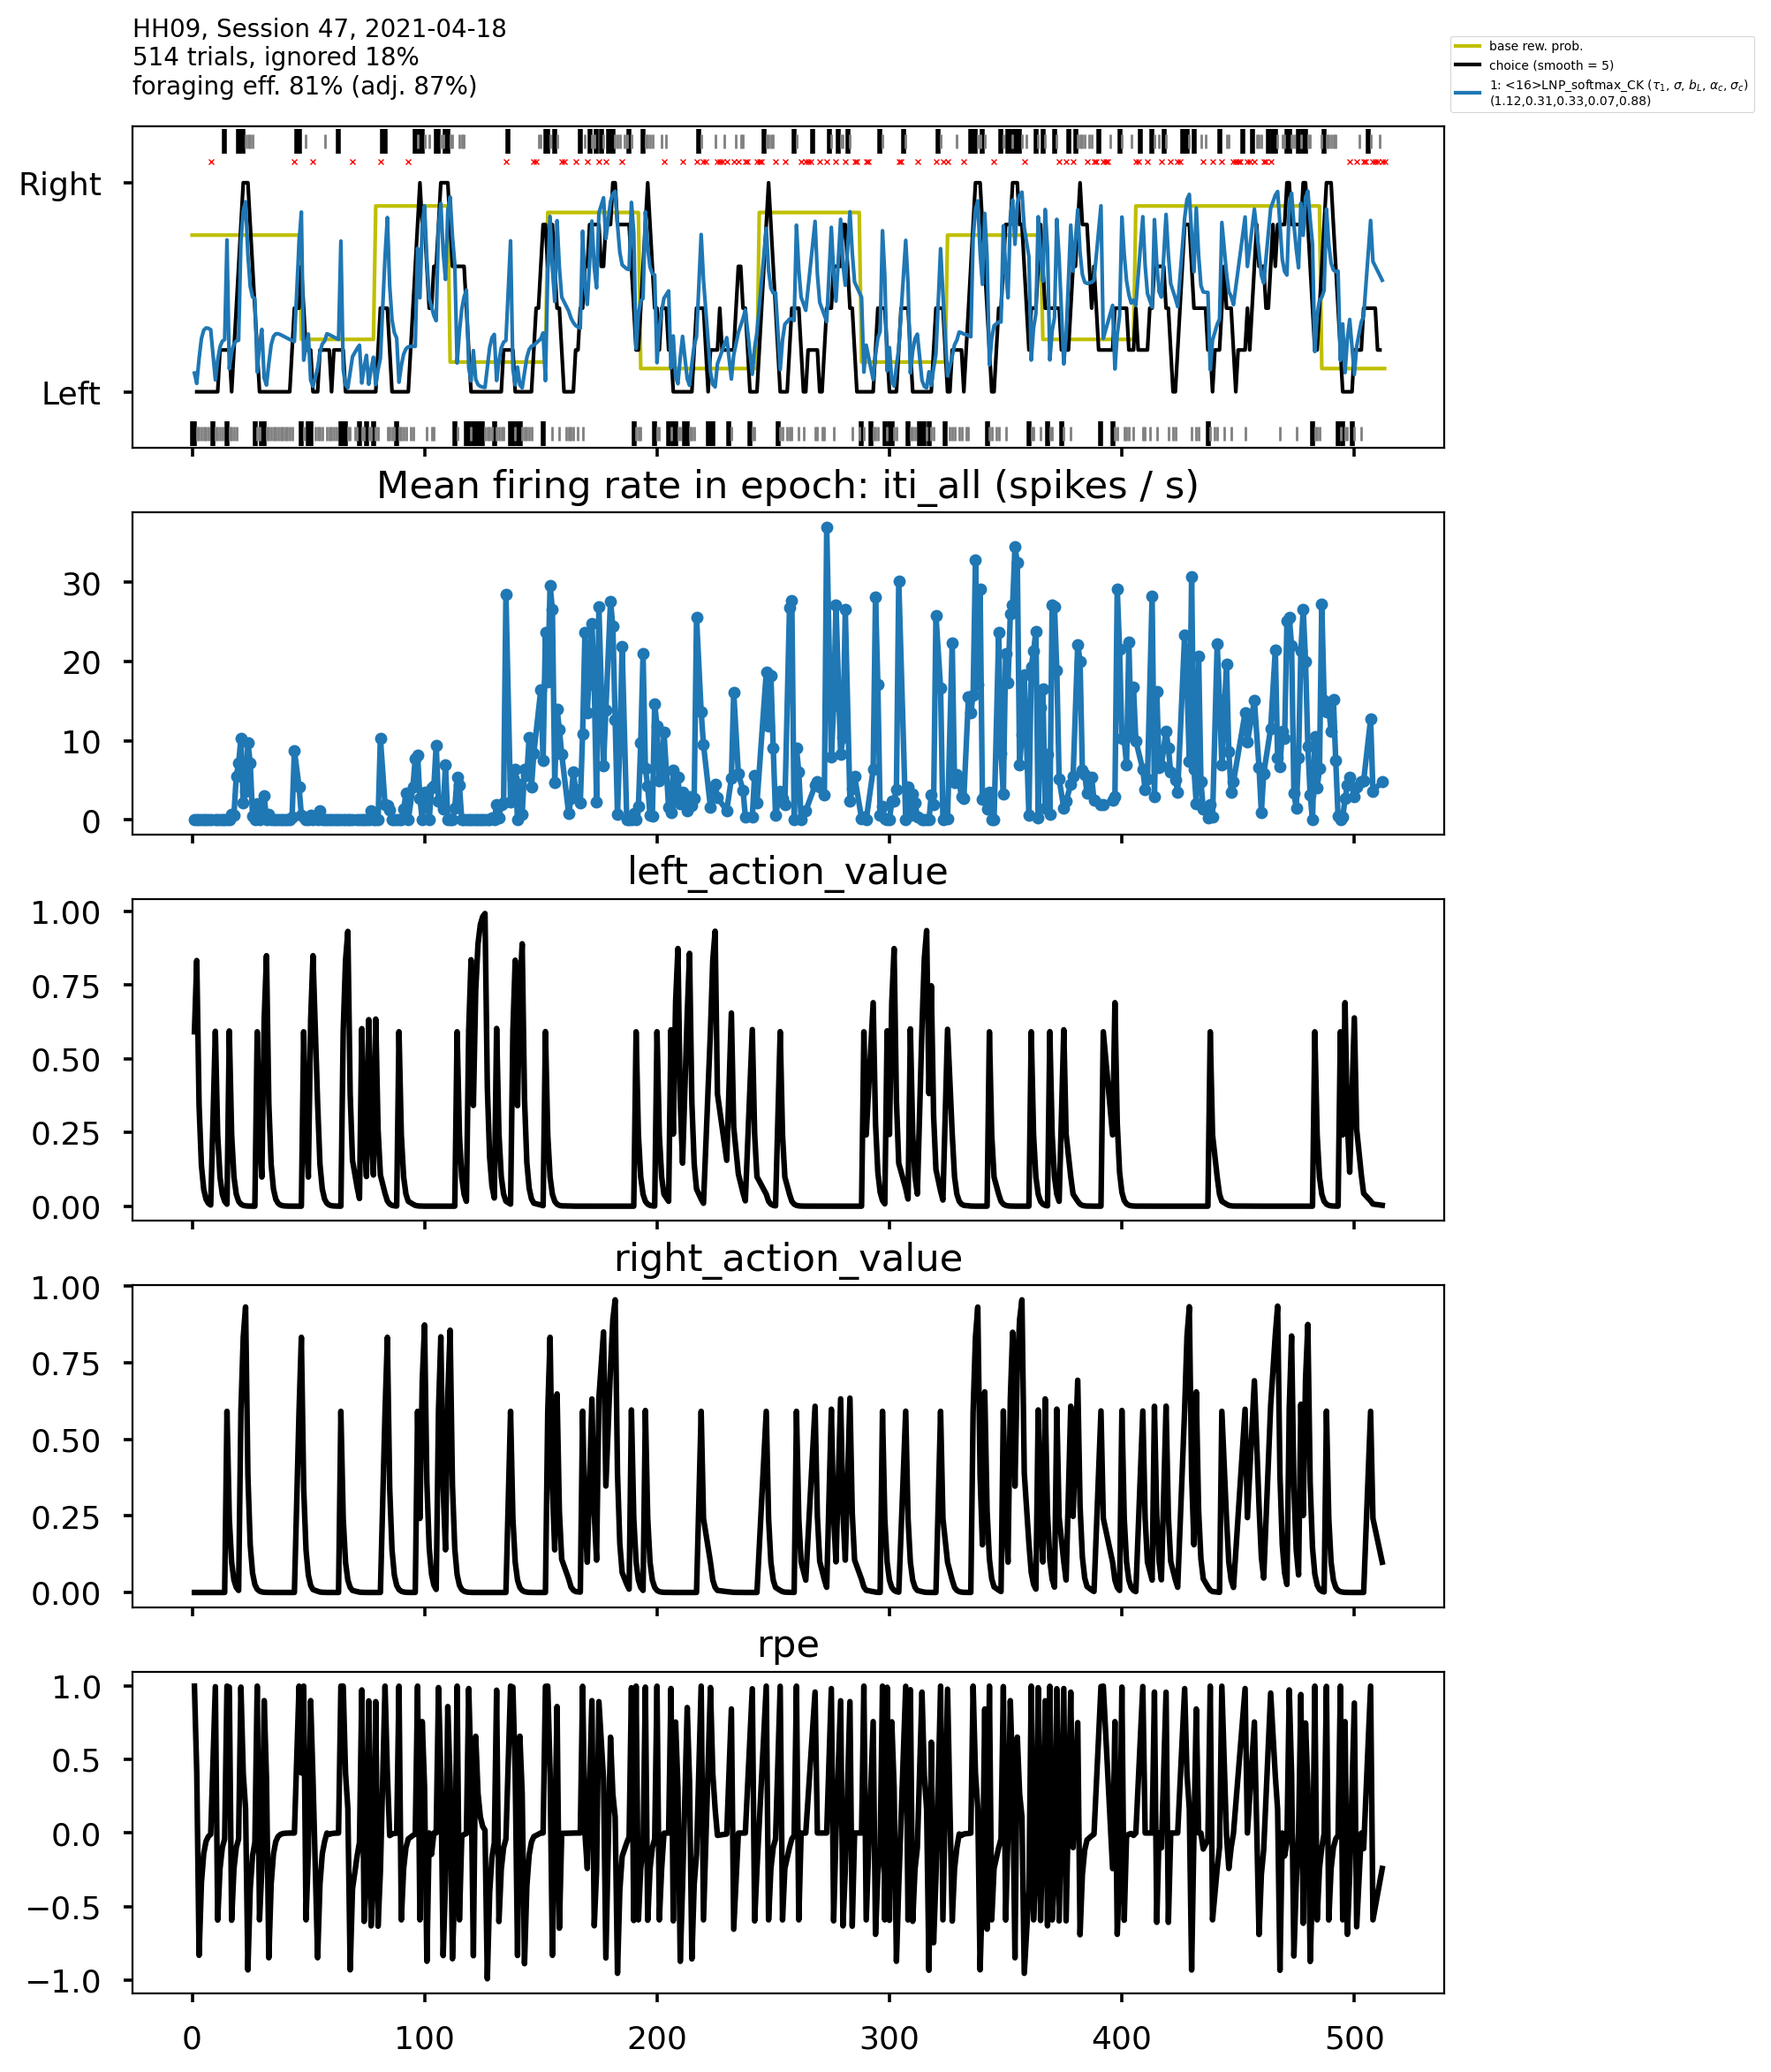

<Figure size 1600x600 with 0 Axes>

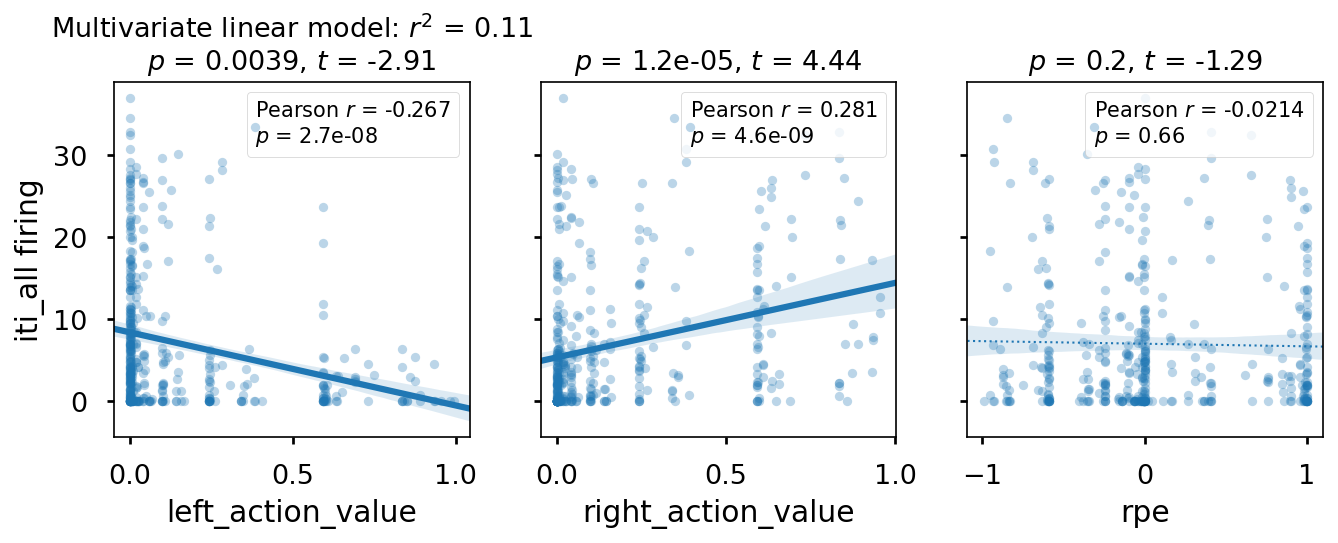

In [9]:
plot_unit_period_tuning()

In [ ]:
plot_session_fitted_choice(unit_key, remove_ignored=False)

In [ ]:
q_lv

In [11]:
experiment.BehaviorTrial()

*subject_id    *session    *trial    task         task_protocol     trial_instruction     early_lick     outcome     auto_water     free_water    
+------------+ +---------+ +-------+ +----------+ +---------------+ +-------------------+ +------------+ +---------+ +------------+ +------------+
447921         1           1         foraging     100               none                  no early       ignore      0              0             
447921         1           2         foraging     100               none                  no early       ignore      0              0             
447921         1           3         foraging     100               none                  early          hit         0              0             
447921         1           4         foraging     100               none                  no early       hit         0              0             
447921         1           5         foraging     100               none                  no early       hit         0              0             
447921         1           6         foraging     100               none                  early          hit         0              0             
447921         1           7         foraging     100               none                  early          hit         0              0             
447921         1           8         foraging     100               none                  no early       hit         0              0             
447921         1           9         foraging     100               none                  early          hit         0              0             
447921         1           10        foraging     100               none                  early          miss        0              0             
447921         1           11        foraging     100               none                  early          hit         0              0             
447921         1           12        foraging     100               none                  early          hit         0              0             
447921         1           13        foraging     100               none                  early          miss        0              0             
447921         1           14        foraging     100               none                  early          miss        0              0             
447921         1           15        foraging     100               none                  early          hit         0              0             
447921         1           16        foraging     100               none                  early          hit         0              0             
447921         1           17        foraging     100               none                  no early       hit         0              0             
447921         1           18        foraging     100               none                  no early       miss        0              0             
447921         1           19        foraging     100               none                  no early       miss        0              0             
447921         1           20        foraging     100               none                  no early       hit         0              0             
447921         1           21        foraging     100               none                  early          miss        0              0             
447921         1           22        foraging     100               none                  no early       hit         0              0             
447921         1           23        foraging     100               none                  no early       miss        0              0             
447921         1           24        foraging     100               none                  early          miss        0              0             
447921         1           25        foraging     100               none                  early          ignore      0              0             
447921         1           26  

#### Behavior

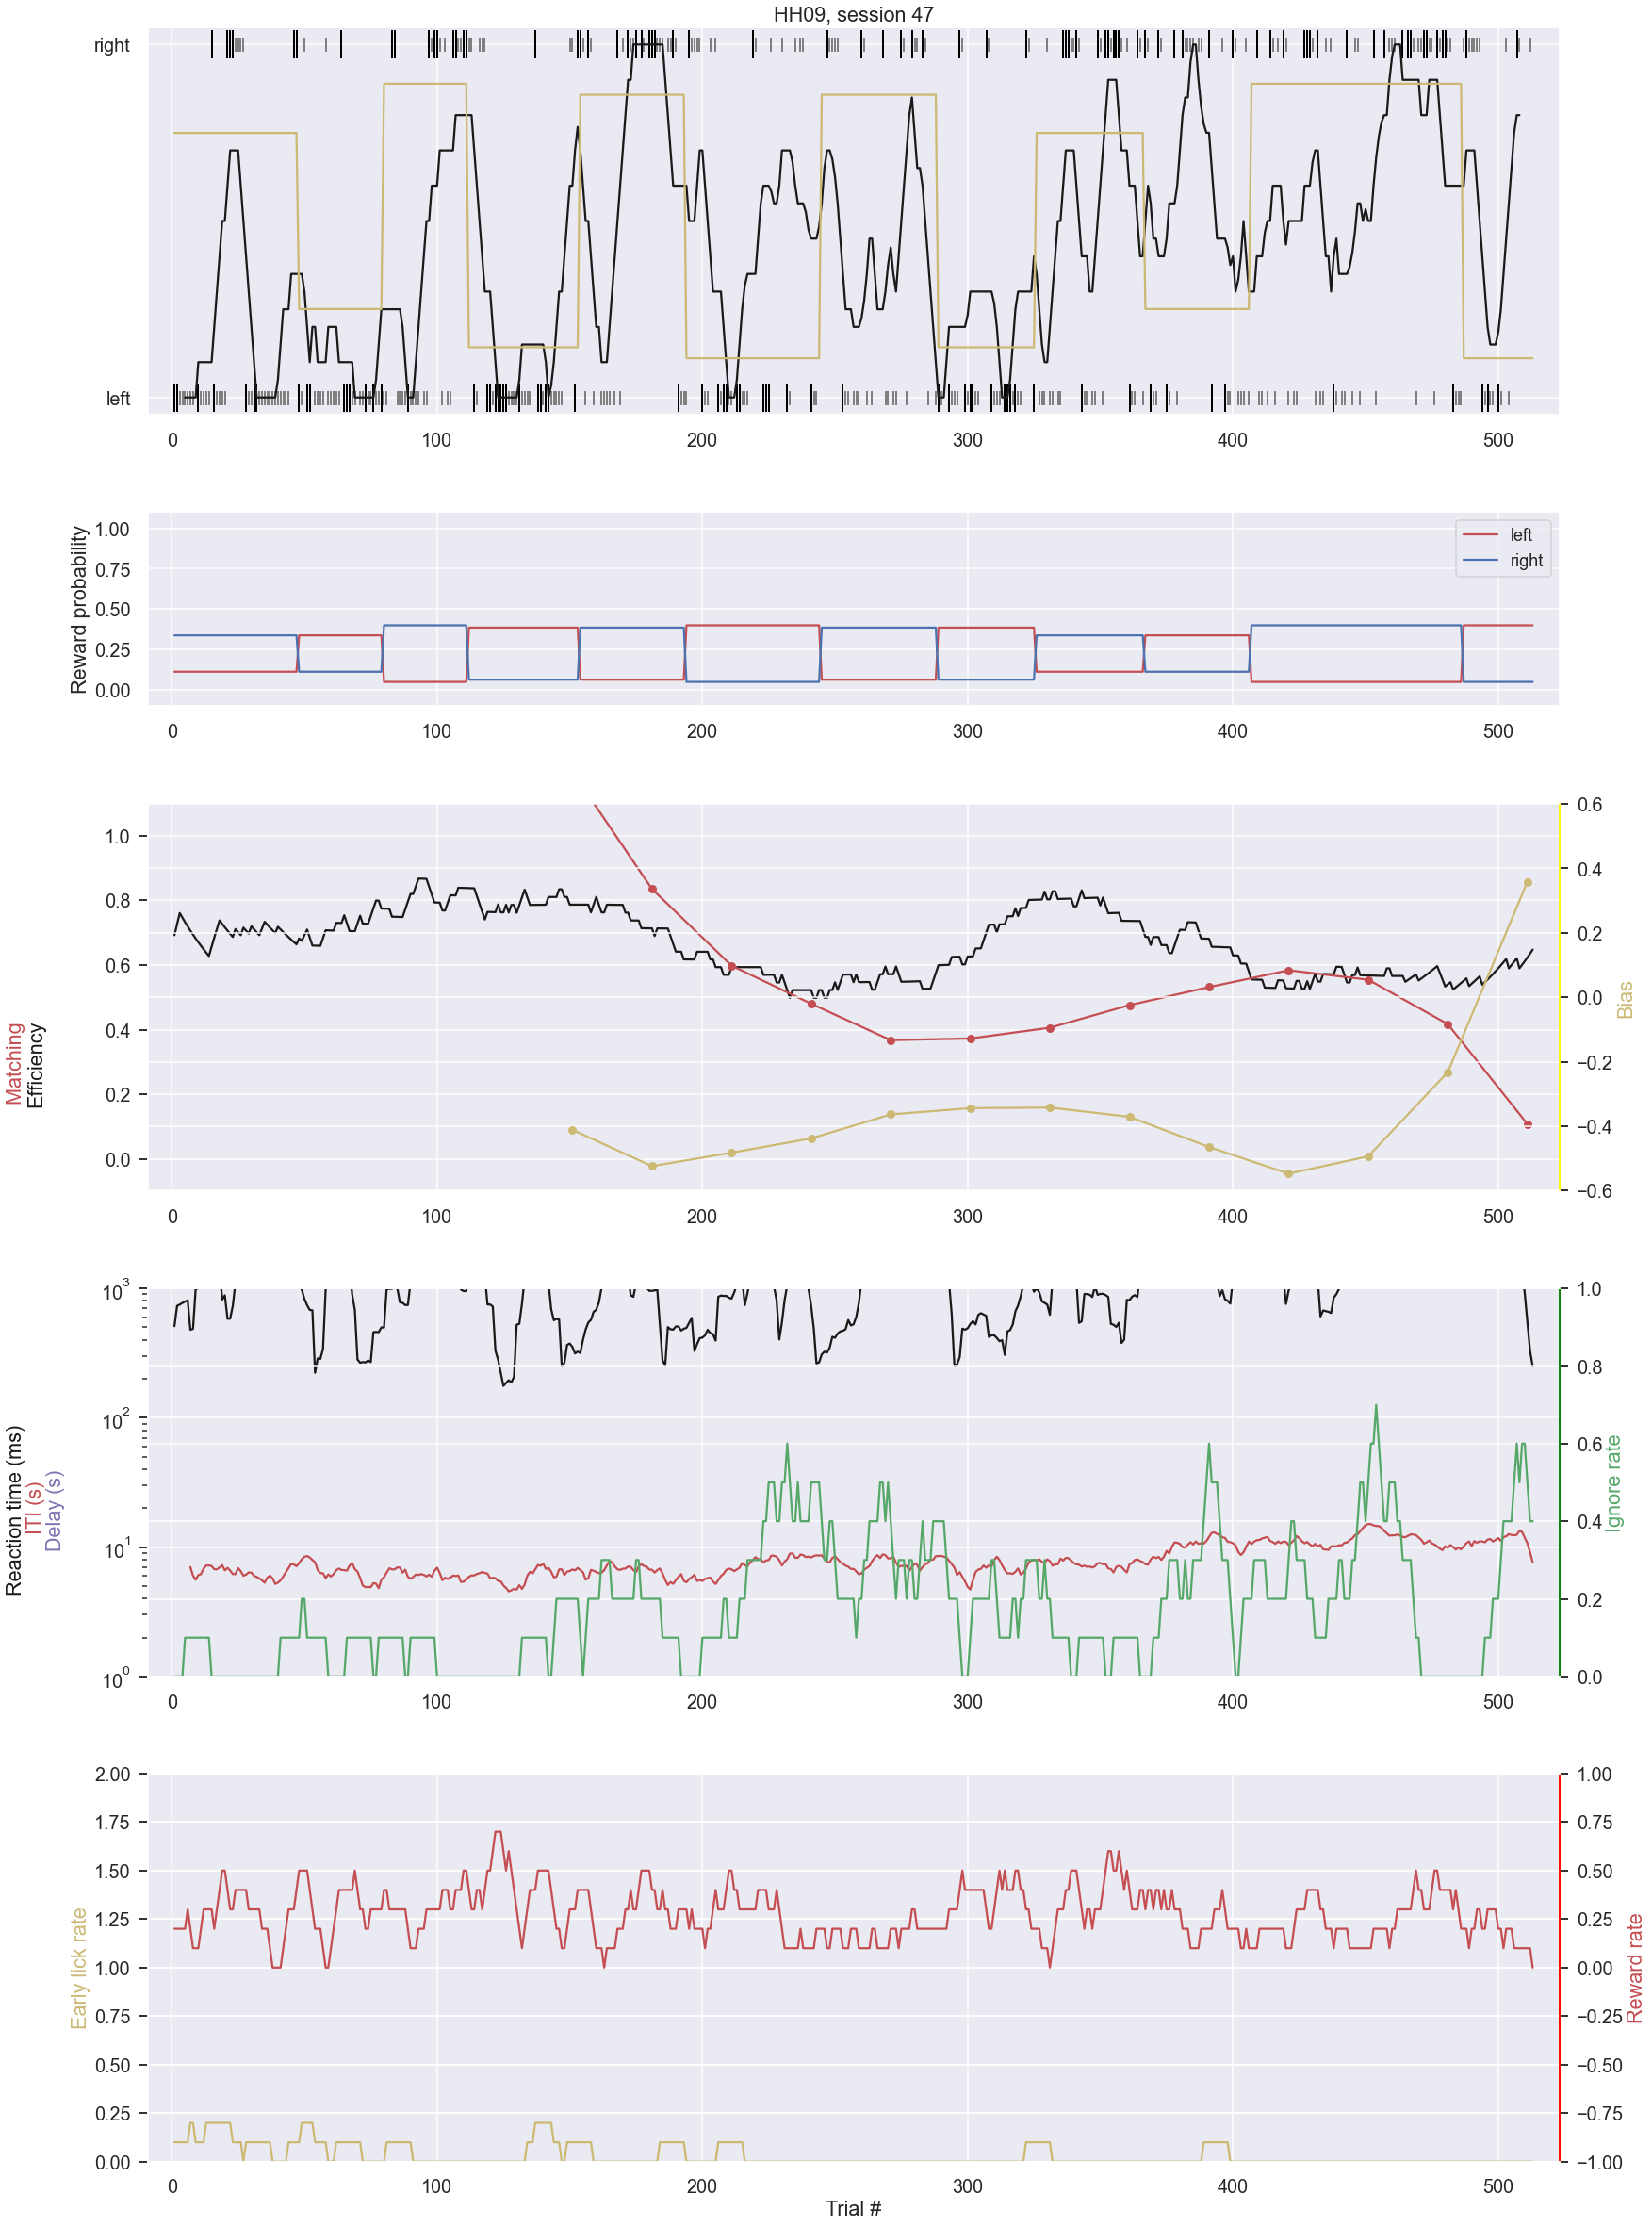

In [12]:
from pipeline.plot.foraging_plot import plot_foragingWebGUI_session
plot_foragingWebGUI_session('HH09', unit_key['session'])